# Machine learning to predict Power output from wind turbine


***

In [1]:
# Numerical arrays
import numpy as np

# Data frames.
import pandas as pd

# Plotting
import matplotlib.pyplot as plt

In [2]:
# Plot style.
plt.style.use("ggplot")

# Plot size.
plt.rcParams['figure.figsize'] = [14, 8]

## 1. Read in and familiarise ourselves with the dataset

In [3]:
# Read in the powerproduction dataset from the Data folder in the repository. Although it is a text file, we can read it in as a csv file, such is the format of the data contained within.
data = pd.read_csv('Data/powerproduction.txt')

In [4]:
# Complete a statistical summary of the dataset
data.describe()

,speed,power
count,500.000000,500.000000
mean,12.590398,48.014584
std,7.224991,41.614572
min,0.000000,0.000000
25%,6.324750,5.288000
50%,12.550500,41.645500
75%,18.775250,93.537000
max,25.000000,113.556000


From this we can see there are 500 data points of speed and corresponding power. The average speed is 12.59 and average power output is 48. Units are not given in the dataset, but based on some research, we will assume the units of speed are m/s (Metres per second) and the power output in MW (MegaWatts)
[https://en.wikipedia.org/wiki/Wind_turbine_design#Design_specification](https://en.wikipedia.org/wiki/Wind_turbine_design#Design_specification)

In [5]:
# View the head of the dataset
data.head(20)

,speed,power
0,0.000,0.000
1,0.125,0.000
2,0.150,0.000
3,0.225,0.000
4,0.275,0.000
5,0.325,4.331
6,0.400,5.186
7,0.450,3.826
8,0.501,1.048
9,0.526,5.553


In [6]:
# View the head of the dataset
data.tail(20)

,speed,power
480,23.974,94.270
481,24.024,105.992
482,24.049,93.524
483,24.174,95.869
484,24.199,101.419
485,24.249,103.700
486,24.299,93.694
487,24.349,93.078
488,24.374,98.223
489,24.399,95.117


At the outset, viewing the head and the tail of the dataset is always a good idea to give us a flavour of the data contained within and to give confidence that the dataset has no obvious flaws or quirks

In [7]:
df = pd.DataFrame(data)
df

,speed,power
0,0.000,0.0
1,0.125,0.0
2,0.150,0.0
3,0.225,0.0
4,0.275,0.0
...,...,...
495,24.775,0.0
496,24.850,0.0
497,24.875,0.0
498,24.950,0.0


<function matplotlib.pyplot.show(close=None, block=None)>

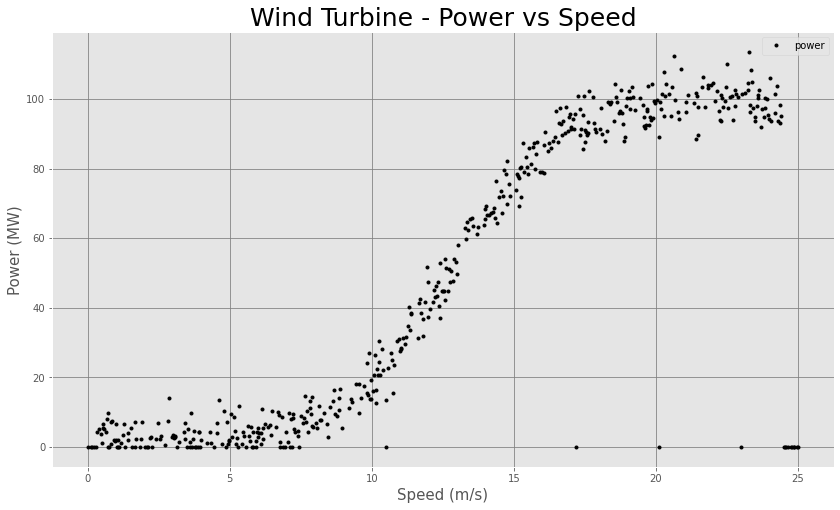

In [8]:
# Plot the values.
df.plot(x="speed", y="power", style='k.')
plt.title('Wind Turbine - Power vs Speed', size=25)
plt.xlabel('Speed (m/s)', size=15)
plt.ylabel('Power (MW)', size=15)
# Show grid lines
plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.show

From a quick observation of the data, we can see that the relationship between Power and Speed has the above trend. Between apporximately 7m/s and 17m/s wind speed, the Power generated varies from <10MW to approximately 100MW. Outside the window of 7m/s to 17m/s there is relatively litte change with increasing or decreasiing wind speed.<br>
It is worth noting that there are a number of outliers showing where zero power is generated despite considerable wind speed being recorded. Because the Power in each of these outliers is exactly 0MW,it is assumed that there is some operational issue with the turbine and it is not working as per normal at these data points. This may be something worth notifying the turbine operator about. However, When modelling it would be worth pre-processing this data to ignore such obvious outliers, as these will skew any model trying to obtain normal operation modelling.

## 2. Pre process the data

From our above observation, we see there are outliers. For each of these outliers, the Power output is zero eventhough the wind speed is considerable. This is particularly noticeable at wind speeds ~>7.5m/s. It is important to deal with outliers prior to modelling or machine learning, as outliers certainly lead to more innacurate results.<br>
The outliers in this dataset are easy to identify from the above plot, hence we will deal wwith them in simple terms. However, with datasets of more than 2 variables, it is most often not as easy to identfy outliers from plotting. In these cases, using mathematical functions such as z-score or IQR score are required.[https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba](https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba).<br>
For the purpose of this assignment, we will assume a zero Power output corresponds to the turbine being turned off, so we will ignore these data points

In [9]:
# delete any rows from the dataset where a zero Power output is recorded
df = df[df.power != 0]
print('Number of rows remaining in dataset: %.d' % len(df))

Number of rows remaining in dataset: 451


<function matplotlib.pyplot.show(close=None, block=None)>

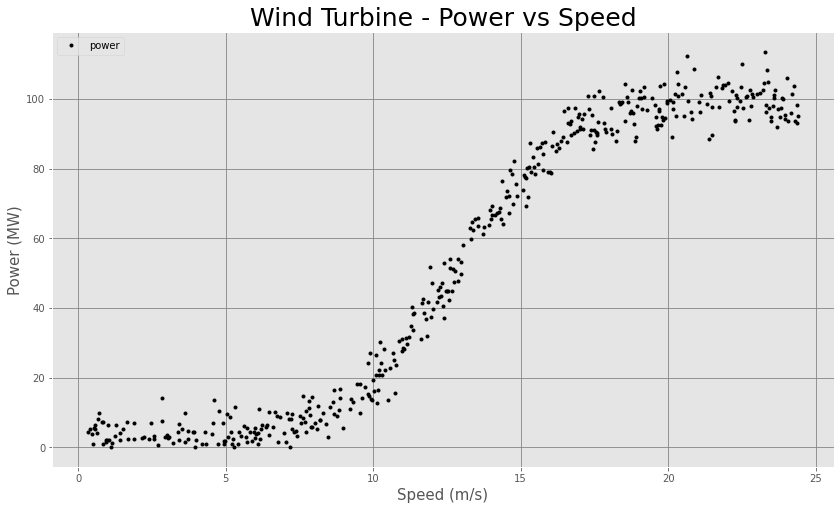

In [10]:
# Plot the values of the dataset with the outliers removed.
df.plot(x="speed", y="power", style='k.')
plt.title('Wind Turbine - Power vs Speed', size=25)
plt.xlabel('Speed (m/s)', size=15)
plt.ylabel('Power (MW)', size=15)
# Show grid lines
plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.show

## 3. Using polyfit function as a regression tool

By experimentation with the below polyfit function in numpy, a polynomial of degree 5 was found to best fit the data. [https://github.com/ianmcloughlin/jupyter-teaching-notebooks/blob/master/regression.ipynb](https://github.com/ianmcloughlin/jupyter-teaching-notebooks/blob/master/regression.ipynb).<br><br>
Below has the calculated coefficients and corresonding fitted line to the data.

In [11]:
# Select the columns of the DataFrame
Speed = df['speed']
Power = df["power"]

In [12]:
# Convert to arrays
x = Speed.to_numpy()
y = Power.to_numpy()

Now, we will use polyfit function in numpy to fit a a line to a set of stat using the least squares [https://en.wikipedia.org/wiki/Least_squares](https://en.wikipedia.org/wiki/Least_squares)

In [13]:
# https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html 
a, b, c, d, e, f = np.polyfit(x, y, 5) 
a, b, c, d, e, f

(0.00039630172192963434,
 -0.02523629166747932,
 0.5364697791523846,
 -4.104980455352897,
 11.155542997851406,
 -2.82537457777539)

These are the coefficients that will best fit the below equation in matching the dataset, as computed by the polyfit function in numpy

$$ y = a x^5 + bx^4 + cx^3 +dx^2 +ex + f $$

Plotting this on the same chart at the dataset, give us an idea of the accuracy of the polyfit

<function matplotlib.pyplot.show(close=None, block=None)>

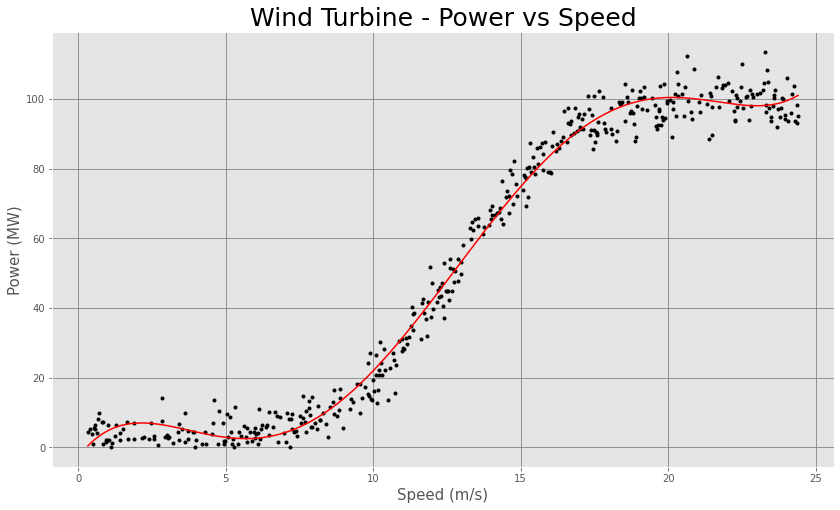

In [14]:
# Plot the values.
#df.plot(x="speed", y="power", style='k.')
plt.plot(x, y, 'k.')
plt.title('Wind Turbine - Power vs Speed', size=25)
plt.xlabel('Speed (m/s)', size=15)
plt.ylabel('Power (MW)', size=15)
# Show grid lines
plt.grid(b=True, which='major', color='grey', linestyle='-')
# Add the plot of the 5th degree polymomial along with the calculated coefficients from polyfit
plt.plot(x, a * x *x*x*x*x + b *x*x*x*x +c *x*x*x +d*x*x +e*x +f, 'r-')
plt.show

Visually, the line seems to track the data set quite well.<br>

## 4. Machine Learning using Scikit-Learn

We will now use scikit-learn to model and obtain the same results as above. The only difference bewteen below and above is that we will obtain the same results by use of scikit learn modelling rather than our own manual playing with the numpy polyfit function. Scikit-learn is an open source machine learning library that supports supervised and unsupervised learning. It also provides various tools for model fitting, data preprocessing, model selection and evaluation, and many other utilities. It provides dozens of built-in machine learning algorithms and models, called estimators. Each estimator can be fitted to some data using its fit method. [https://scikit-learn.org/](https://scikit-learn.org/)

### 4.1 Train the model

In [15]:
# Import required scikit learn libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures

When modelling a dataset, it is normal to divide the dataset into data that will be used for training/developing the model, and a test set of data that will be used for testing the model. Below, we will split the dataset so that two thirds of the data is used for training and one third is set aside for testing later. The train_test_split function in scikit learn allows us to randomly select test data from the full dataset. It is important that the test data is randomly taken from the dataset to ensure an accurate cross section of the dataset is contained within it.

In [16]:
# Prepare the dataset for training and testing
data = df.values
# split into inpiut and output elements
X, y = data[:, :-1], data[:, -1]
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

From section 3 above, we feel confident that a 5th degree polynomial will achieve a reasonable model. Prior to fitting the model, it is necessary to convert the X_train to a new matrix, X_Poly, which consists of all the polynomial combinations of features with degree=5. [https://towardsdatascience.com/machine-learning-basics-polynomial-regression-3f9dd30223d1](https://towardsdatascience.com/machine-learning-basics-polynomial-regression-3f9dd30223d1)

In [17]:
# fit the model using a 5th degree polynomial
poly_reg = PolynomialFeatures(degree = 5) 
X_poly = poly_reg.fit_transform(X_train)

Using the transformed X-train values and the corresponding y_train values, we will select a model of LinearRegession contained within sciit learn [https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html). This uses the mathematical method of Ordinary Least Squares, which works to minimize the sum of the squares of the differences between the observed recorded y_train in the given dataset and those y values predicted by the linear function. [https://statisticsbyjim.com/glossary/ordinary-least-squares/](https://statisticsbyjim.com/glossary/ordinary-least-squares/)

In [18]:
model = LinearRegression()
model.fit(X_poly, y_train)

LinearRegression()

With the model developed, we will now plot the actual data against the the predicted data for the same input speed.

In [19]:
# Calculate the predicted y values from passing the given X_train values through the model
y_pred = model.predict(X_poly)

### 4.2 Analyse the model

<function matplotlib.pyplot.show(close=None, block=None)>

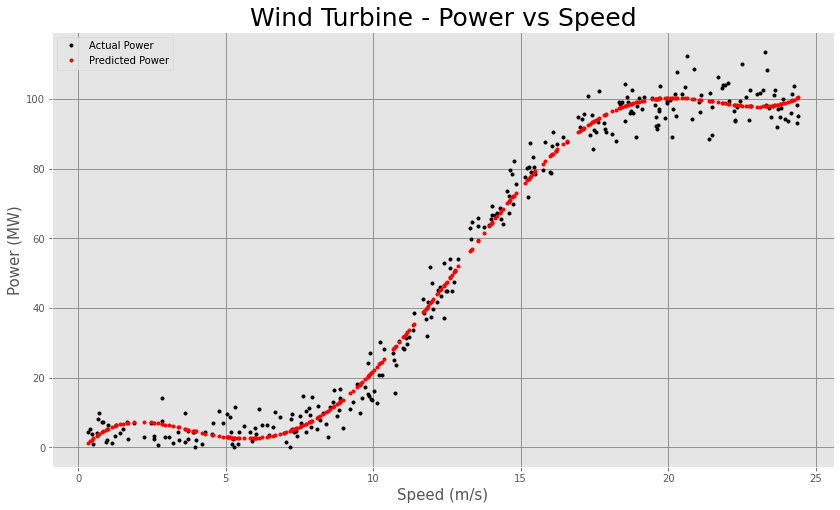

In [20]:
# Plot the results.
plt.plot(X_train, y_train, 'k.',label='Actual Power')
plt.plot(X_train, y_pred, 'r.',label='Predicted Power')
plt.title('Wind Turbine - Power vs Speed', size=25)
plt.xlabel('Speed (m/s)', size=15)
plt.ylabel('Power (MW)', size=15)
# Show grid lines
plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.legend()
plt.show

Above shows the results of the training dataset compared to the actual training data results. However, this only shows the results of the model using the data that was used to train the model. This cannot be used as a measure of how good the model is. To properly test the model, we will use the test data extracted from the full dataset earlier and NOT used in the training of the model. This is the real test of how good the model is.

In [21]:
# Prepare the x data to be used in a polynomial of 5th degree
poly_reg = PolynomialFeatures(degree = 5) 
X_test_poly = poly_reg.fit_transform(X_test)

# Calculate the predicted y values from passing the given X_train values through the model
y_test_pred = model.predict(X_test_poly)

<function matplotlib.pyplot.show(close=None, block=None)>

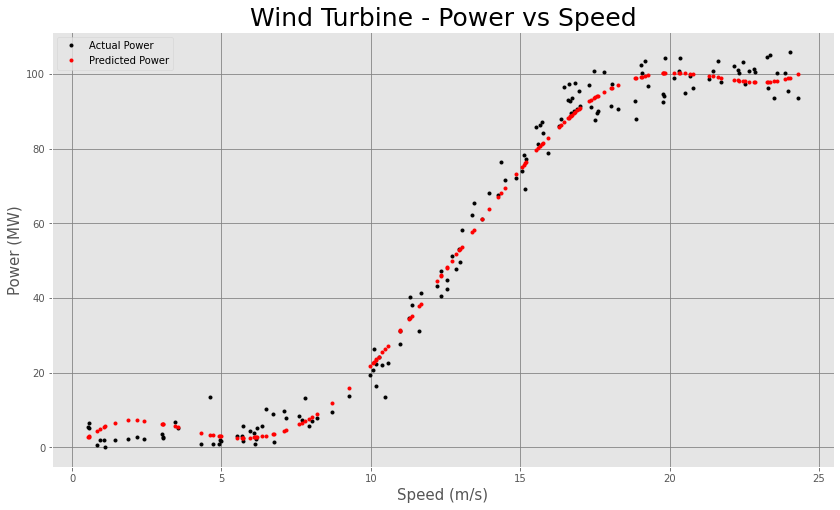

In [22]:
# Plot the results.
plt.plot(X_test, y_test, 'k.',label='Actual Power')
plt.plot(X_test, y_test_pred, 'r.',label='Predicted Power')
plt.title('Wind Turbine - Power vs Speed', size=25)
plt.xlabel('Speed (m/s)', size=15)
plt.ylabel('Power (MW)', size=15)
# Show grid lines
plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.legend()
plt.show

From the chart, we can see the predicted Power (red dots) looks pretty accurate to the actual Power recorded (black dots). We can use some measures to understand how accurate the model is.

The relationship is measured with a value called the r-squared is used to measure the accuracy between the actual y test data and the model predicted y data. The r-squared value ranges from 0 to 1, where 0 means no correlation, and 1 means 100% correlation.[https://statisticsbyjim.com/regression/interpret-r-squared-regression/](https://statisticsbyjim.com/regression/interpret-r-squared-regression/)

In [23]:
from sklearn.metrics import r2_score
Rsquared = r2_score(y_test, y_test_pred)
print('R-squared: %.5f' %Rsquared)

R-squared: 0.98884


This R-squared value suggests a very accurate model

In [24]:
#Calculate the accuracy of the y predicted results with the y actual results for the test dataset
mae = mean_absolute_error(y_test, y_test_pred)
print('MAE: %.3fMW' % mae)

MAE: 3.487MW


In [25]:
from sklearn.metrics import max_error
max_error = max_error(y_test, y_test_pred)
print('Max error: %.3fMW' % max_error)

Max error: 12.870MW


Using the regression model above, we get a mean absolute error between the actual power output of the turbine and the predicted output power of 3.487MW, and a maximum eroor across the test dataset of 12.87MW

## 5. Machine Learning using Neural Networks

Whereas section 4 used traditional calculus of finding the coefficients of an equation to best fit a line to the set of data, there is another approach that has become popular with the advent of computers. The neural network approach involves starting out with an initial approximation of a model, looks at it's performance, and slowly changes certain parameters to refine the approximation. Over many hundred's of thousands of iterations of this technique, the initial model becomes more and more refined. Note, there is a lot of calculus involved in this approach also, but it just approaches the problem from a different perspective. After an initial model is built, and the first data passed through it, calculus is used to calculate the loss (How accurate the model is). [https://en.wikipedia.org/wiki/Gradient_descent](https://en.wikipedia.org/wiki/Gradient_descent). Then, using what is observed from this calculation, an algorithm is used to modify weights and biases contained within the neural network that should produce a more accurate model on the next iteration.   

We will now construct a neural network that will use machine learning to train a model to fit to the powerProduction dataset, which consists of 1 input (wind speed) and 1 output (Power). Therefore, our Neural network required for this is relatively simple, with no need for deep neural networks. <br>
Below, by varing certain characteristics, we will build 5 neural networks, apply the training data set to each network (running 5000 epochs), and compare the predicted output Power values with the actual Power obtained for both the training dataset and the test dataset. The 5 conditions of network we will examine are outlined below: <br>

1. Hidden layer with 1 neuron, and default batch size of 1
2. Hidden layer with 1 neuron and batch size of 10
3. Hidden layer with 2 neurons and batch size of 10
4. Hidden layer with 3 neurons and batch siize of 10
5. Hidden layer with 5 neurons and batch size of 10<br><br>

We will compute the loss obtained on each experiment and compare accuracy results to see if we can find one model that stands out as being better than the others. We will also compare the accuracy of this Neural network approack to the above approach in section 4.

### 5.1 - Test model consisting of: 1 neuron, 5000 epochs, batch size=1

In [26]:
#Import tensorflow library required for Neural networks.
import tensorflow.keras as kr

The first neural network we will build and test will consist of an input neuron, which will consist of our X_train values. This will be connected to 1 neuron in the hidden layer. As well as the value of the input, the connection will have a weight associated with it. This weight can vary between 0 and 1. The neuron in the hidden layer will have a bias (similar to a weight), which can also vary between 0 and 1. The input value to the hidden layer neuron is calculated by multiplying the x-value from the input neuron by the weight of the connection. To this value, the hidden layer bias is added and an activation function is applied to it to produce the output value from the hidden layer neuron. So, there are 3 different manipluations of the input x-value that can take place between leaving the input neuron and leaving the hidden layer neuron:<br>
1. x value is multiplied by w
2. b is added to (x*w)
3. a function is applied to (b + (x*W)). ie 

$$ f(b +(x*w)) $$<br>

The output value from the hidden layer neuron then experiences a weight manipulation from the connection layer between the hidden layer and the output layer neuron. Also, the output layer applies it's bias and it's actiivation function to the incoming value. Therfore, the input x value has 2 rounds of f, b and w being applied to it by the time it beomces the output of the network, or

$$ y = f_{1}(b_{1} +(x*w_{1})) + f_{2}(b_{2} +(x*w_{2})) $$
<br>

This is the case for 1 hidden layer consisting of 1 neuron. In later examples we will be adding neurons. In these cases, the above can be expressed as

$$ y = \sum\limits_{i=1}^n f_{i}(b_{i} +(x*w_{i})) $$

![1-neuron](Images/1-neuron.JPG)<br><p style='text-align: right;'>(http://alexlenail.me/NN-SVG/index.html, 2020)</p>

Below explains the deatils of each line in the building of a model in keras. There is a lot of details contained within each line. It is very important to understand these details, as these are what deterimine if your model works and how acurate it is, so please read the comments.

In [27]:
# Build a model using Keras
model = kr.models.Sequential()

# Add a layer with 1 neuron, 1 input (wind speed), using the sigmoid activation function applied to each neuron. 
# Initialise weights and bias with Glorot_uniform. This Draws samples from a uniform distribution within [-limit, limit], 
# where limit = sqrt(6 / (fan_in + fan_out)) (fan_in is the number of input units in the weight tensor and fan_out is the 
# number of output units).https://www.tensorflow.org/api_docs/python/tf/keras/initializers/GlorotUniform
model.add(kr.layers.Dense(1, input_shape=(1,), activation='sigmoid', kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform"))

# Add a layer for the output neuron (Power), using 1 neuron, a linear activation function and, again, glorot_uniform 
# initialisers. Note, we use a linear activation function in this last layer, as we know power outputs are >1, which is the 
# approx the maximum we would obtain if we used a sigmoid activation function at this layer.
model.add(kr.layers.Dense(1, activation='linear', kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform"))

# Compile the model using the above defined neural network, calculating the loss after each epoch using "mean_squared_error"
# method, and applying the Optimizer that implements the Adam algorithm used to affect small changes to weights and baises,
# based on the loss calculated after each eopch.https://keras.io/api/optimizers/adam/
model.compile(kr.optimizers.Adam(lr=0.001), loss='mean_squared_error')

Note: The running of the below neural networks takes considerable time. Please be aware of this and patient if run

In [28]:
# Fit the training dataset to the above model and run 5000 epochs in batches of 1 at a time.
model.fit(X_train, y_train, epochs=5000, batch_size=1)

Epoch 1/5000
302/302 [==============================] - 1s 853us/step - loss: 4543.7317
Epoch 2/5000
302/302 [==============================] - 0s 777us/step - loss: 4611.4381
Epoch 3/5000
302/302 [==============================] - 0s 784us/step - loss: 4109.0466
Epoch 4/5000
302/302 [==============================] - 0s 788us/step - loss: 5090.5635
Epoch 5/5000
302/302 [==============================] - 0s 780us/step - loss: 3973.1109
Epoch 6/5000
302/302 [==============================] - 0s 797us/step - loss: 4448.5936
Epoch 7/5000
302/302 [==============================] - 0s 895us/step - loss: 4433.6656
Epoch 8/5000
302/302 [==============================] - 0s 938us/step - loss: 4522.9841
Epoch 9/5000
302/302 [==============================] - 0s 778us/step - loss: 4108.2164
Epoch 10/5000
302/302 [==============================] - 0s 846us/step - loss: 4447.2721
Epoch 11/5000
302/302 [==============================] - 0s 813us/step - loss: 4187.2271
Epoch 12/5000
302/302 [=======

Epoch 182/5000
302/302 [==============================] - 0s 763us/step - loss: 1712.9846
Epoch 183/5000
302/302 [==============================] - 0s 768us/step - loss: 1363.9949
Epoch 184/5000
302/302 [==============================] - 0s 770us/step - loss: 1414.5055
Epoch 185/5000
302/302 [==============================] - 0s 754us/step - loss: 1587.9515
Epoch 186/5000
302/302 [==============================] - 0s 756us/step - loss: 1579.94430s - loss: 158
Epoch 187/5000
302/302 [==============================] - 0s 767us/step - loss: 1530.0892
Epoch 188/5000
302/302 [==============================] - 0s 766us/step - loss: 1377.7804
Epoch 189/5000
302/302 [==============================] - 0s 822us/step - loss: 1545.0037
Epoch 190/5000
302/302 [==============================] - 0s 834us/step - loss: 1512.4887
Epoch 191/5000
302/302 [==============================] - 0s 812us/step - loss: 1418.5387
Epoch 192/5000
302/302 [==============================] - 0s 754us/step - loss: 1553.8

302/302 [==============================] - 0s 772us/step - loss: 844.2723
Epoch 273/5000
302/302 [==============================] - 0s 765us/step - loss: 852.4684
Epoch 274/5000
302/302 [==============================] - 0s 759us/step - loss: 861.9819
Epoch 275/5000
302/302 [==============================] - 0s 767us/step - loss: 847.9015
Epoch 276/5000
302/302 [==============================] - 0s 783us/step - loss: 805.8482
Epoch 277/5000
302/302 [==============================] - 0s 758us/step - loss: 874.9511
Epoch 278/5000
302/302 [==============================] - 0s 761us/step - loss: 893.1987
Epoch 279/5000
302/302 [==============================] - 0s 764us/step - loss: 832.5517
Epoch 280/5000
302/302 [==============================] - 0s 825us/step - loss: 798.9020
Epoch 281/5000
302/302 [==============================] - 0s 759us/step - loss: 814.2017
Epoch 282/5000
302/302 [==============================] - 0s 769us/step - loss: 791.5273
Epoch 283/5000
302/302 [============

302/302 [==============================] - 0s 773us/step - loss: 194.6792
Epoch 455/5000
302/302 [==============================] - 0s 786us/step - loss: 185.9115
Epoch 456/5000
302/302 [==============================] - 0s 748us/step - loss: 166.2369
Epoch 457/5000
302/302 [==============================] - 0s 754us/step - loss: 163.0510
Epoch 458/5000
302/302 [==============================] - 0s 776us/step - loss: 152.4600
Epoch 459/5000
302/302 [==============================] - 0s 770us/step - loss: 171.8403
Epoch 460/5000
302/302 [==============================] - 0s 772us/step - loss: 164.7525 0s - loss: 164.401
Epoch 461/5000
302/302 [==============================] - 0s 851us/step - loss: 146.9447
Epoch 462/5000
302/302 [==============================] - 0s 842us/step - loss: 163.8164
Epoch 463/5000
302/302 [==============================] - 0s 773us/step - loss: 151.7148
Epoch 464/5000
302/302 [==============================] - 0s 773us/step - loss: 150.4700
Epoch 465/5000
30

302/302 [==============================] - 0s 834us/step - loss: 41.2878
Epoch 638/5000
302/302 [==============================] - 0s 764us/step - loss: 44.7350
Epoch 639/5000
302/302 [==============================] - 0s 765us/step - loss: 44.4459
Epoch 640/5000
302/302 [==============================] - 0s 951us/step - loss: 42.9675
Epoch 641/5000
302/302 [==============================] - 0s 847us/step - loss: 49.8170
Epoch 642/5000
302/302 [==============================] - 0s 851us/step - loss: 43.1553
Epoch 643/5000
302/302 [==============================] - 0s 761us/step - loss: 42.9063
Epoch 644/5000
302/302 [==============================] - 0s 769us/step - loss: 42.6619
Epoch 645/5000
302/302 [==============================] - 0s 841us/step - loss: 42.6206
Epoch 646/5000
302/302 [==============================] - 0s 762us/step - loss: 39.5064
Epoch 647/5000
302/302 [==============================] - 0s 823us/step - loss: 42.1778
Epoch 648/5000
302/302 [=======================

302/302 [==============================] - 0s 780us/step - loss: 27.3618
Epoch 822/5000
302/302 [==============================] - 0s 770us/step - loss: 27.3295
Epoch 823/5000
302/302 [==============================] - 0s 841us/step - loss: 28.4698
Epoch 824/5000
302/302 [==============================] - 0s 769us/step - loss: 26.6030
Epoch 825/5000
302/302 [==============================] - 0s 764us/step - loss: 25.6082
Epoch 826/5000
302/302 [==============================] - 0s 754us/step - loss: 24.7448
Epoch 827/5000
302/302 [==============================] - 0s 768us/step - loss: 31.5914
Epoch 828/5000
302/302 [==============================] - 0s 770us/step - loss: 23.2412
Epoch 829/5000
302/302 [==============================] - 0s 761us/step - loss: 28.2300
Epoch 830/5000
302/302 [==============================] - 0s 854us/step - loss: 26.6373
Epoch 831/5000
302/302 [==============================] - 0s 752us/step - loss: 32.0343
Epoch 832/5000
302/302 [=======================

Epoch 914/5000
302/302 [==============================] - 0s 776us/step - loss: 17.2852
Epoch 915/5000
302/302 [==============================] - 0s 768us/step - loss: 21.8365
Epoch 916/5000
302/302 [==============================] - 0s 781us/step - loss: 23.6487
Epoch 917/5000
302/302 [==============================] - 0s 773us/step - loss: 25.95020s - loss: 27.
Epoch 918/5000
302/302 [==============================] - 0s 771us/step - loss: 26.6396
Epoch 919/5000
302/302 [==============================] - 0s 795us/step - loss: 21.4191
Epoch 920/5000
302/302 [==============================] - 0s 769us/step - loss: 24.0881
Epoch 921/5000
302/302 [==============================] - 0s 763us/step - loss: 18.6115
Epoch 922/5000
302/302 [==============================] - 0s 761us/step - loss: 21.4953
Epoch 923/5000
302/302 [==============================] - 0s 769us/step - loss: 21.3967
Epoch 924/5000
302/302 [==============================] - 0s 766us/step - loss: 25.2059
Epoch 925/5000
302

302/302 [==============================] - 0s 970us/step - loss: 21.2641
Epoch 1099/5000
302/302 [==============================] - 0s 963us/step - loss: 21.1432
Epoch 1100/5000
302/302 [==============================] - 0s 963us/step - loss: 19.5541
Epoch 1101/5000
302/302 [==============================] - 0s 930us/step - loss: 19.2808
Epoch 1102/5000
302/302 [==============================] - 0s 841us/step - loss: 17.9474
Epoch 1103/5000
302/302 [==============================] - 0s 914us/step - loss: 17.7930
Epoch 1104/5000
302/302 [==============================] - 0s 890us/step - loss: 17.5865
Epoch 1105/5000
302/302 [==============================] - 0s 776us/step - loss: 18.4362
Epoch 1106/5000
302/302 [==============================] - 0s 864us/step - loss: 16.7901
Epoch 1107/5000
302/302 [==============================] - 0s 950us/step - loss: 19.0607
Epoch 1108/5000
302/302 [==============================] - 0s 914us/step - loss: 18.6943
Epoch 1109/5000
302/302 [============

302/302 [==============================] - 0s 872us/step - loss: 21.3460
Epoch 1277/5000
302/302 [==============================] - 0s 879us/step - loss: 16.2456
Epoch 1278/5000
302/302 [==============================] - 0s 790us/step - loss: 19.2390
Epoch 1279/5000
302/302 [==============================] - 0s 803us/step - loss: 17.6583
Epoch 1280/5000
302/302 [==============================] - 0s 833us/step - loss: 19.3151
Epoch 1281/5000
302/302 [==============================] - 0s 811us/step - loss: 17.30970s - loss: 17.07
Epoch 1282/5000
302/302 [==============================] - 0s 778us/step - loss: 14.6591
Epoch 1283/5000
302/302 [==============================] - 0s 883us/step - loss: 16.3548
Epoch 1284/5000
302/302 [==============================] - 0s 780us/step - loss: 19.4169
Epoch 1285/5000
302/302 [==============================] - 0s 793us/step - loss: 17.2674
Epoch 1286/5000
302/302 [==============================] - 0s 798us/step - loss: 18.86130s - loss: 18.
Epoch 1

302/302 [==============================] - 0s 770us/step - loss: 18.1681
Epoch 1458/5000
302/302 [==============================] - 0s 769us/step - loss: 17.67010s - loss: 1
Epoch 1459/5000
302/302 [==============================] - 0s 752us/step - loss: 16.2124
Epoch 1460/5000
302/302 [==============================] - 0s 760us/step - loss: 17.1868
Epoch 1461/5000
302/302 [==============================] - 0s 763us/step - loss: 18.1221
Epoch 1462/5000
302/302 [==============================] - 0s 768us/step - loss: 17.5661
Epoch 1463/5000
302/302 [==============================] - 0s 761us/step - loss: 16.2312
Epoch 1464/5000
302/302 [==============================] - 0s 775us/step - loss: 18.5537
Epoch 1465/5000
302/302 [==============================] - 0s 827us/step - loss: 18.8317
Epoch 1466/5000
302/302 [==============================] - 0s 760us/step - loss: 19.2750
Epoch 1467/5000
302/302 [==============================] - 0s 757us/step - loss: 19.2195
Epoch 1468/5000
302/302 [

302/302 [==============================] - 0s 768us/step - loss: 19.9464
Epoch 1641/5000
302/302 [==============================] - 0s 849us/step - loss: 18.7999
Epoch 1642/5000
302/302 [==============================] - 0s 830us/step - loss: 18.7254
Epoch 1643/5000
302/302 [==============================] - 0s 760us/step - loss: 17.2524
Epoch 1644/5000
302/302 [==============================] - 0s 767us/step - loss: 20.0755
Epoch 1645/5000
302/302 [==============================] - 0s 812us/step - loss: 14.9264
Epoch 1646/5000
302/302 [==============================] - 0s 757us/step - loss: 19.8982
Epoch 1647/5000
302/302 [==============================] - 0s 768us/step - loss: 19.3648
Epoch 1648/5000
302/302 [==============================] - 0s 791us/step - loss: 17.1987
Epoch 1649/5000
302/302 [==============================] - 0s 761us/step - loss: 22.3481
Epoch 1650/5000
302/302 [==============================] - 0s 763us/step - loss: 18.3757
Epoch 1651/5000
302/302 [============

302/302 [==============================] - 0s 769us/step - loss: 20.1840
Epoch 1823/5000
302/302 [==============================] - 0s 835us/step - loss: 18.1571
Epoch 1824/5000
302/302 [==============================] - 0s 781us/step - loss: 19.0005
Epoch 1825/5000
302/302 [==============================] - 0s 786us/step - loss: 15.6619
Epoch 1826/5000
302/302 [==============================] - 0s 832us/step - loss: 18.0012
Epoch 1827/5000
302/302 [==============================] - 0s 750us/step - loss: 20.8730
Epoch 1828/5000
302/302 [==============================] - 0s 920us/step - loss: 18.7258
Epoch 1829/5000
302/302 [==============================] - 0s 763us/step - loss: 20.5210
Epoch 1830/5000
302/302 [==============================] - 0s 780us/step - loss: 17.6650
Epoch 1831/5000
302/302 [==============================] - 0s 754us/step - loss: 22.8061
Epoch 1832/5000
302/302 [==============================] - 0s 764us/step - loss: 20.3532
Epoch 1833/5000
302/302 [============

302/302 [==============================] - 0s 887us/step - loss: 19.7407
Epoch 2005/5000
302/302 [==============================] - 0s 829us/step - loss: 17.8572
Epoch 2006/5000
302/302 [==============================] - 0s 758us/step - loss: 18.0022
Epoch 2007/5000
302/302 [==============================] - 0s 877us/step - loss: 18.1544
Epoch 2008/5000
302/302 [==============================] - 0s 867us/step - loss: 19.6874
Epoch 2009/5000
302/302 [==============================] - 0s 870us/step - loss: 18.7590
Epoch 2010/5000
302/302 [==============================] - 0s 897us/step - loss: 16.3845
Epoch 2011/5000
302/302 [==============================] - 0s 874us/step - loss: 18.5449
Epoch 2012/5000
302/302 [==============================] - 0s 894us/step - loss: 18.9792
Epoch 2013/5000
302/302 [==============================] - 0s 857us/step - loss: 17.1028
Epoch 2014/5000
302/302 [==============================] - 0s 843us/step - loss: 17.5640
Epoch 2015/5000
302/302 [============

302/302 [==============================] - 0s 770us/step - loss: 16.6013
Epoch 2187/5000
302/302 [==============================] - 0s 765us/step - loss: 18.1094
Epoch 2188/5000
302/302 [==============================] - 0s 764us/step - loss: 18.0723
Epoch 2189/5000
302/302 [==============================] - 0s 767us/step - loss: 21.2385
Epoch 2190/5000
302/302 [==============================] - 0s 762us/step - loss: 17.3569
Epoch 2191/5000
302/302 [==============================] - 0s 769us/step - loss: 18.5939
Epoch 2192/5000
302/302 [==============================] - 0s 765us/step - loss: 16.0738
Epoch 2193/5000
302/302 [==============================] - 0s 765us/step - loss: 19.0097
Epoch 2194/5000
302/302 [==============================] - 0s 765us/step - loss: 16.1990
Epoch 2195/5000
302/302 [==============================] - 0s 762us/step - loss: 17.3580
Epoch 2196/5000
302/302 [==============================] - 0s 765us/step - loss: 19.1534
Epoch 2197/5000
302/302 [============

302/302 [==============================] - 0s 777us/step - loss: 18.7705
Epoch 2369/5000
302/302 [==============================] - 0s 811us/step - loss: 17.3964
Epoch 2370/5000
302/302 [==============================] - 0s 764us/step - loss: 18.1789
Epoch 2371/5000
302/302 [==============================] - 0s 765us/step - loss: 17.8820
Epoch 2372/5000
302/302 [==============================] - 0s 763us/step - loss: 17.5219
Epoch 2373/5000
302/302 [==============================] - 0s 766us/step - loss: 21.4264
Epoch 2374/5000
302/302 [==============================] - 0s 767us/step - loss: 21.6234
Epoch 2375/5000
302/302 [==============================] - 0s 769us/step - loss: 17.6726
Epoch 2376/5000
302/302 [==============================] - 0s 776us/step - loss: 16.3177
Epoch 2377/5000
302/302 [==============================] - 0s 767us/step - loss: 20.0446
Epoch 2378/5000
302/302 [==============================] - 0s 765us/step - loss: 20.3069
Epoch 2379/5000
302/302 [============

302/302 [==============================] - 0s 765us/step - loss: 18.6096
Epoch 2552/5000
302/302 [==============================] - 0s 761us/step - loss: 17.7508
Epoch 2553/5000
302/302 [==============================] - 0s 754us/step - loss: 17.3409
Epoch 2554/5000
302/302 [==============================] - 0s 741us/step - loss: 19.3760
Epoch 2555/5000
302/302 [==============================] - 0s 726us/step - loss: 19.7924
Epoch 2556/5000
302/302 [==============================] - 0s 765us/step - loss: 19.3758
Epoch 2557/5000
302/302 [==============================] - ETA: 0s - loss: 17.55 - 0s 745us/step - loss: 17.6287
Epoch 2558/5000
302/302 [==============================] - 0s 751us/step - loss: 16.6390
Epoch 2559/5000
302/302 [==============================] - 0s 754us/step - loss: 22.00250s - loss:
Epoch 2560/5000
302/302 [==============================] - 0s 749us/step - loss: 16.4819
Epoch 2561/5000
302/302 [==============================] - 0s 788us/step - loss: 19.3952
Epo

Epoch 2642/5000
302/302 [==============================] - 0s 760us/step - loss: 15.3987
Epoch 2643/5000
302/302 [==============================] - 0s 799us/step - loss: 23.5734
Epoch 2644/5000
302/302 [==============================] - 0s 755us/step - loss: 18.9816
Epoch 2645/5000
302/302 [==============================] - 0s 753us/step - loss: 18.9908
Epoch 2646/5000
302/302 [==============================] - 0s 767us/step - loss: 17.4346
Epoch 2647/5000
302/302 [==============================] - 0s 789us/step - loss: 17.5876
Epoch 2648/5000
302/302 [==============================] - 0s 773us/step - loss: 17.7159
Epoch 2649/5000
302/302 [==============================] - 0s 769us/step - loss: 14.9777
Epoch 2650/5000
302/302 [==============================] - 0s 753us/step - loss: 17.8566
Epoch 2651/5000
302/302 [==============================] - 0s 748us/step - loss: 18.3104
Epoch 2652/5000
302/302 [==============================] - 0s 747us/step - loss: 20.9134
Epoch 2653/5000
302/3

302/302 [==============================] - 0s 753us/step - loss: 20.8266
Epoch 2735/5000
302/302 [==============================] - 0s 749us/step - loss: 17.5330
Epoch 2736/5000
302/302 [==============================] - 0s 759us/step - loss: 19.5864
Epoch 2737/5000
302/302 [==============================] - 0s 762us/step - loss: 20.0344
Epoch 2738/5000
302/302 [==============================] - 0s 783us/step - loss: 18.5187
Epoch 2739/5000
302/302 [==============================] - 0s 766us/step - loss: 17.1224
Epoch 2740/5000
302/302 [==============================] - 0s 751us/step - loss: 19.5032
Epoch 2741/5000
302/302 [==============================] - 0s 743us/step - loss: 18.3999
Epoch 2742/5000
302/302 [==============================] - 0s 852us/step - loss: 20.3915
Epoch 2743/5000
302/302 [==============================] - 0s 802us/step - loss: 19.9921
Epoch 2744/5000
302/302 [==============================] - 0s 760us/step - loss: 15.6695
Epoch 2745/5000
302/302 [============

302/302 [==============================] - 0s 810us/step - loss: 20.7127
Epoch 2916/5000
302/302 [==============================] - 0s 769us/step - loss: 18.4905
Epoch 2917/5000
302/302 [==============================] - 0s 754us/step - loss: 16.6060
Epoch 2918/5000
302/302 [==============================] - 0s 794us/step - loss: 18.9528
Epoch 2919/5000
302/302 [==============================] - 0s 848us/step - loss: 17.6439
Epoch 2920/5000
302/302 [==============================] - 0s 752us/step - loss: 18.7251
Epoch 2921/5000
302/302 [==============================] - 0s 748us/step - loss: 16.3268
Epoch 2922/5000
302/302 [==============================] - 0s 747us/step - loss: 19.3920
Epoch 2923/5000
302/302 [==============================] - 0s 752us/step - loss: 17.0294
Epoch 2924/5000
302/302 [==============================] - 0s 747us/step - loss: 18.1842
Epoch 2925/5000
302/302 [==============================] - 0s 749us/step - loss: 19.2022
Epoch 2926/5000
302/302 [============

302/302 [==============================] - 0s 711us/step - loss: 17.7637
Epoch 3098/5000
302/302 [==============================] - ETA: 0s - loss: 20.04 - 0s 754us/step - loss: 19.8622
Epoch 3099/5000
302/302 [==============================] - 0s 749us/step - loss: 13.9032
Epoch 3100/5000
302/302 [==============================] - 0s 760us/step - loss: 18.3306
Epoch 3101/5000
302/302 [==============================] - 0s 750us/step - loss: 16.8203
Epoch 3102/5000
302/302 [==============================] - 0s 750us/step - loss: 21.1043
Epoch 3103/5000
302/302 [==============================] - 0s 754us/step - loss: 19.9356
Epoch 3104/5000
302/302 [==============================] - 0s 748us/step - loss: 21.0544
Epoch 3105/5000
302/302 [==============================] - 0s 764us/step - loss: 18.4128
Epoch 3106/5000
302/302 [==============================] - 0s 755us/step - loss: 18.4535
Epoch 3107/5000
302/302 [==============================] - 0s 773us/step - loss: 17.0550
Epoch 3108/50

302/302 [==============================] - 0s 720us/step - loss: 19.3435
Epoch 3279/5000
302/302 [==============================] - 0s 764us/step - loss: 17.8384
Epoch 3280/5000
302/302 [==============================] - 0s 757us/step - loss: 19.2073
Epoch 3281/5000
302/302 [==============================] - 0s 752us/step - loss: 19.3784
Epoch 3282/5000
302/302 [==============================] - 0s 745us/step - loss: 17.3711
Epoch 3283/5000
302/302 [==============================] - 0s 773us/step - loss: 17.5744
Epoch 3284/5000
302/302 [==============================] - 0s 752us/step - loss: 18.3084
Epoch 3285/5000
302/302 [==============================] - 0s 753us/step - loss: 16.1467
Epoch 3286/5000
302/302 [==============================] - 0s 748us/step - loss: 16.6937
Epoch 3287/5000
302/302 [==============================] - 0s 764us/step - loss: 18.9223
Epoch 3288/5000
302/302 [==============================] - 0s 747us/step - loss: 14.5257
Epoch 3289/5000
302/302 [============

Epoch 3461/5000
302/302 [==============================] - 0s 749us/step - loss: 17.9649
Epoch 3462/5000
302/302 [==============================] - 0s 711us/step - loss: 15.6584
Epoch 3463/5000
302/302 [==============================] - 0s 766us/step - loss: 17.1214
Epoch 3464/5000
302/302 [==============================] - 0s 756us/step - loss: 14.7013
Epoch 3465/5000
302/302 [==============================] - 0s 762us/step - loss: 17.3762
Epoch 3466/5000
302/302 [==============================] - 0s 757us/step - loss: 17.2007
Epoch 3467/5000
302/302 [==============================] - 0s 748us/step - loss: 17.3270
Epoch 3468/5000
302/302 [==============================] - 0s 762us/step - loss: 18.5701
Epoch 3469/5000
302/302 [==============================] - 0s 749us/step - loss: 17.6518
Epoch 3470/5000
302/302 [==============================] - 0s 754us/step - loss: 16.9298
Epoch 3471/5000
302/302 [==============================] - 0s 722us/step - loss: 20.3587
Epoch 3472/5000
302/3

302/302 [==============================] - 0s 752us/step - loss: 19.6471
Epoch 3644/5000
302/302 [==============================] - 0s 769us/step - loss: 16.8091
Epoch 3645/5000
302/302 [==============================] - 0s 752us/step - loss: 21.6878
Epoch 3646/5000
302/302 [==============================] - 0s 758us/step - loss: 19.9919
Epoch 3647/5000
302/302 [==============================] - 0s 762us/step - loss: 20.17420s - loss:
Epoch 3648/5000
302/302 [==============================] - 0s 766us/step - loss: 20.7787
Epoch 3649/5000
302/302 [==============================] - 0s 757us/step - loss: 18.5387
Epoch 3650/5000
302/302 [==============================] - 0s 756us/step - loss: 19.9782
Epoch 3651/5000
302/302 [==============================] - 0s 755us/step - loss: 18.8168
Epoch 3652/5000
302/302 [==============================] - 0s 751us/step - loss: 21.0684
Epoch 3653/5000
302/302 [==============================] - 0s 718us/step - loss: 17.8844
Epoch 3654/5000
302/302 [==

302/302 [==============================] - 0s 755us/step - loss: 17.6845
Epoch 3826/5000
302/302 [==============================] - 0s 751us/step - loss: 16.7300
Epoch 3827/5000
302/302 [==============================] - 0s 745us/step - loss: 18.4502
Epoch 3828/5000
302/302 [==============================] - 0s 746us/step - loss: 17.0582
Epoch 3829/5000
302/302 [==============================] - 0s 752us/step - loss: 18.2106
Epoch 3830/5000
302/302 [==============================] - 0s 764us/step - loss: 16.8770
Epoch 3831/5000
302/302 [==============================] - 0s 763us/step - loss: 17.6948
Epoch 3832/5000
302/302 [==============================] - 0s 750us/step - loss: 17.4103
Epoch 3833/5000
302/302 [==============================] - 0s 748us/step - loss: 16.6038
Epoch 3834/5000
302/302 [==============================] - 0s 750us/step - loss: 18.9908
Epoch 3835/5000
302/302 [==============================] - 0s 739us/step - loss: 17.6120
Epoch 3836/5000
302/302 [============

302/302 [==============================] - 0s 741us/step - loss: 16.0636
Epoch 4008/5000
302/302 [==============================] - 0s 758us/step - loss: 16.7239
Epoch 4009/5000
302/302 [==============================] - 0s 743us/step - loss: 23.0667
Epoch 4010/5000
302/302 [==============================] - 0s 754us/step - loss: 16.3937
Epoch 4011/5000
302/302 [==============================] - 0s 742us/step - loss: 19.4724
Epoch 4012/5000
302/302 [==============================] - 0s 745us/step - loss: 17.3398
Epoch 4013/5000
302/302 [==============================] - 0s 743us/step - loss: 16.8082
Epoch 4014/5000
302/302 [==============================] - 0s 765us/step - loss: 21.9110
Epoch 4015/5000
302/302 [==============================] - 0s 745us/step - loss: 19.2369
Epoch 4016/5000
302/302 [==============================] - 0s 748us/step - loss: 17.8968
Epoch 4017/5000
302/302 [==============================] - 0s 752us/step - loss: 17.6986
Epoch 4018/5000
302/302 [============

Epoch 4189/5000
302/302 [==============================] - 0s 729us/step - loss: 15.5398
Epoch 4190/5000
302/302 [==============================] - 0s 770us/step - loss: 17.1725
Epoch 4191/5000
302/302 [==============================] - 0s 753us/step - loss: 18.1359
Epoch 4192/5000
302/302 [==============================] - 0s 759us/step - loss: 17.9708
Epoch 4193/5000
302/302 [==============================] - 0s 754us/step - loss: 16.5936
Epoch 4194/5000
302/302 [==============================] - 0s 768us/step - loss: 18.3198
Epoch 4195/5000
302/302 [==============================] - 0s 750us/step - loss: 16.6502
Epoch 4196/5000
302/302 [==============================] - 0s 748us/step - loss: 20.9851
Epoch 4197/5000
302/302 [==============================] - 0s 762us/step - loss: 18.1743
Epoch 4198/5000
302/302 [==============================] - 0s 757us/step - loss: 17.7619
Epoch 4199/5000
302/302 [==============================] - 0s 767us/step - loss: 18.2352
Epoch 4200/5000
302/3

302/302 [==============================] - 0s 792us/step - loss: 17.8175
Epoch 4281/5000
302/302 [==============================] - 0s 764us/step - loss: 19.0464
Epoch 4282/5000
302/302 [==============================] - 0s 760us/step - loss: 18.3864
Epoch 4283/5000
302/302 [==============================] - 0s 765us/step - loss: 20.7997
Epoch 4284/5000
302/302 [==============================] - 0s 893us/step - loss: 18.28230s - loss:
Epoch 4285/5000
302/302 [==============================] - 0s 750us/step - loss: 15.7063
Epoch 4286/5000
302/302 [==============================] - 0s 749us/step - loss: 16.5506
Epoch 4287/5000
302/302 [==============================] - 0s 728us/step - loss: 16.4374
Epoch 4288/5000
302/302 [==============================] - 0s 761us/step - loss: 18.0393
Epoch 4289/5000
302/302 [==============================] - 0s 759us/step - loss: 18.4758
Epoch 4290/5000
302/302 [==============================] - 0s 747us/step - loss: 18.8746
Epoch 4291/5000
302/302 [==

302/302 [==============================] - 0s 758us/step - loss: 19.5608
Epoch 4373/5000
302/302 [==============================] - 0s 754us/step - loss: 17.8364
Epoch 4374/5000
302/302 [==============================] - 0s 763us/step - loss: 19.9857
Epoch 4375/5000
302/302 [==============================] - 0s 757us/step - loss: 18.4065
Epoch 4376/5000
302/302 [==============================] - 0s 757us/step - loss: 17.3113
Epoch 4377/5000
302/302 [==============================] - 0s 756us/step - loss: 20.6527
Epoch 4378/5000
302/302 [==============================] - 0s 751us/step - loss: 18.4141
Epoch 4379/5000
302/302 [==============================] - 0s 749us/step - loss: 17.5012
Epoch 4380/5000
302/302 [==============================] - 0s 755us/step - loss: 17.5281
Epoch 4381/5000
302/302 [==============================] - 0s 733us/step - loss: 15.57010s - loss: 14.
Epoch 4382/5000
302/302 [==============================] - 0s 748us/step - loss: 19.2406
Epoch 4383/5000
302/302

302/302 [==============================] - 0s 762us/step - loss: 21.32530s - loss: 22.79
Epoch 4555/5000
302/302 [==============================] - 0s 728us/step - loss: 18.0369
Epoch 4556/5000
302/302 [==============================] - 0s 721us/step - loss: 18.0389
Epoch 4557/5000
302/302 [==============================] - 0s 767us/step - loss: 19.5061
Epoch 4558/5000
302/302 [==============================] - 0s 749us/step - loss: 18.2700
Epoch 4559/5000
302/302 [==============================] - 0s 763us/step - loss: 17.8274
Epoch 4560/5000
302/302 [==============================] - 0s 755us/step - loss: 20.3320
Epoch 4561/5000
302/302 [==============================] - 0s 748us/step - loss: 18.2199
Epoch 4562/5000
302/302 [==============================] - 0s 746us/step - loss: 17.5341
Epoch 4563/5000
302/302 [==============================] - 0s 744us/step - loss: 17.1369
Epoch 4564/5000
302/302 [==============================] - 0s 757us/step - loss: 15.2788
Epoch 4565/5000
302/3

302/302 [==============================] - 0s 756us/step - loss: 18.7378
Epoch 4646/5000
302/302 [==============================] - 0s 745us/step - loss: 20.3297
Epoch 4647/5000
302/302 [==============================] - 0s 749us/step - loss: 19.3165
Epoch 4648/5000
302/302 [==============================] - 0s 750us/step - loss: 19.5113
Epoch 4649/5000
302/302 [==============================] - 0s 747us/step - loss: 20.9116
Epoch 4650/5000
302/302 [==============================] - 0s 738us/step - loss: 15.6677
Epoch 4651/5000
302/302 [==============================] - 0s 755us/step - loss: 18.4508
Epoch 4652/5000
302/302 [==============================] - 0s 757us/step - loss: 19.1310
Epoch 4653/5000
302/302 [==============================] - 0s 759us/step - loss: 17.5783
Epoch 4654/5000
302/302 [==============================] - 0s 760us/step - loss: 19.6002
Epoch 4655/5000
302/302 [==============================] - 0s 750us/step - loss: 18.0831
Epoch 4656/5000
302/302 [============

302/302 [==============================] - 0s 724us/step - loss: 17.7413
Epoch 4828/5000
302/302 [==============================] - 0s 753us/step - loss: 21.3199
Epoch 4829/5000
302/302 [==============================] - 0s 743us/step - loss: 18.1213
Epoch 4830/5000
302/302 [==============================] - 0s 753us/step - loss: 18.0228
Epoch 4831/5000
302/302 [==============================] - 0s 749us/step - loss: 15.0804
Epoch 4832/5000
302/302 [==============================] - 0s 752us/step - loss: 18.3088
Epoch 4833/5000
302/302 [==============================] - 0s 763us/step - loss: 20.9615
Epoch 4834/5000
302/302 [==============================] - 0s 750us/step - loss: 19.2454
Epoch 4835/5000
302/302 [==============================] - 0s 741us/step - loss: 17.7373
Epoch 4836/5000
302/302 [==============================] - 0s 741us/step - loss: 19.8716
Epoch 4837/5000
302/302 [==============================] - 0s 738us/step - loss: 18.2335
Epoch 4838/5000
302/302 [============

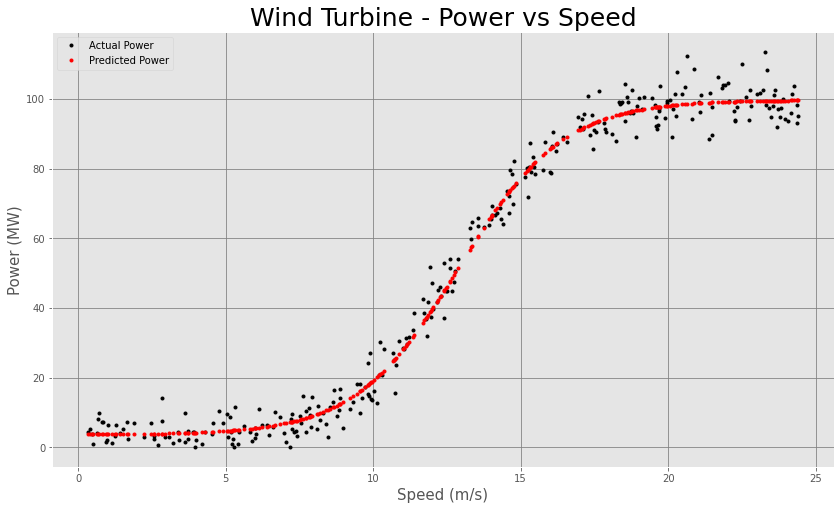

In [29]:
# Now let's see what the train dataset looks like for both the actual data and the predicted values from the model
plt.plot(X_train, y_train, 'k.', label='Actual Power')
plt.plot(X_train, model.predict(X_train), 'r.', label='Predicted Power')
plt.title('Wind Turbine - Power vs Speed', size=25)
plt.xlabel('Speed (m/s)', size=15)
plt.ylabel('Power (MW)', size=15)
# Show grid lines
plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.legend()

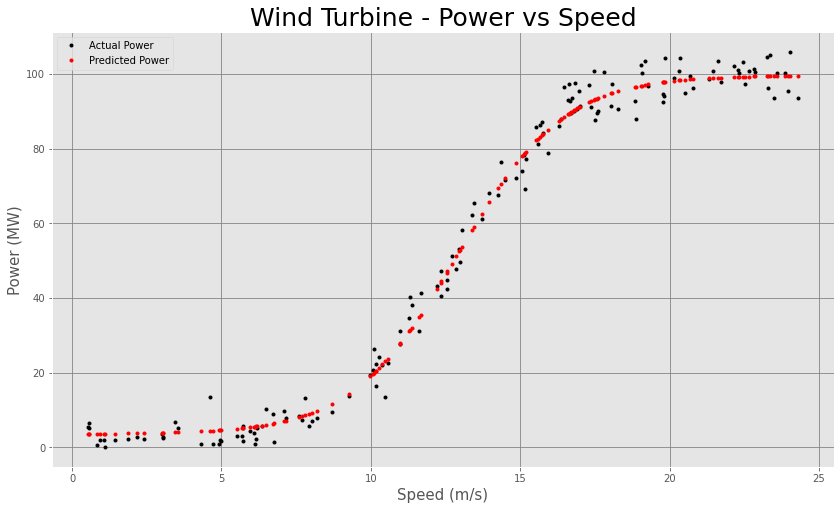

In [30]:
# The ultimate test is how the test dataset fits to its predicted reusults
# Now let's see how the test sample actual and predicted results compare, using the trained model
plt.plot(X_test, y_test, 'k.', label='Actual Power')
plt.plot(X_test, model.predict(X_test), 'r.', label='Predicted Power')
plt.title('Wind Turbine - Power vs Speed', size=25)
plt.xlabel('Speed (m/s)', size=15)
plt.ylabel('Power (MW)', size=15)
# Show grid lines
plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.legend()

In [31]:
# Evaluate the neural network on the test data.
model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 989us/step - loss: 14.5650


14.564977645874023

In [32]:
y_pred = model.predict(X_test)

In [33]:
y_test.shape = (-1,1)

In [34]:
# Using the R-squared, we can measure the accuracy of the Nueral network using the test dataset
Rsquared = r2_score(y_test, y_pred)
print('R-squared: %.5f' %Rsquared)

R-squared: 0.99104


### 5.2 - Test model consisting of: 1 neuron, 5000 epochs, batch size=10

Using the same model as above, we will fit a model by loading inputs in batches of 10 beteen each run of the optimizer

In [35]:
# Fit the training dataset to the above model and run 5000 epochs in batches of 10 at a time.
model.fit(X_train, y_train, epochs=5000, batch_size=10)

Epoch 1/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9644
Epoch 2/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9155
Epoch 3/5000
31/31 [==============================] - 0s 2ms/step - loss: 17.9119
Epoch 4/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.8930
Epoch 5/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.8919
Epoch 6/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.8882
Epoch 7/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9265
Epoch 8/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.8898
Epoch 9/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9147
Epoch 10/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9312
Epoch 11/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9338
Epoch 12/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9291
Epoch 13/5000

31/31 [==============================] - 0s 1ms/step - loss: 17.9301
Epoch 197/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9990
Epoch 198/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0311
Epoch 199/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9666
Epoch 200/5000
31/31 [==============================] - 0s 2ms/step - loss: 17.9327
Epoch 201/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0213
Epoch 202/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0643
Epoch 203/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9655
Epoch 204/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9574
Epoch 205/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9735
Epoch 206/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9494
Epoch 207/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9044
Epoch 2

31/31 [==============================] - 0s 1ms/step - loss: 18.0030
Epoch 391/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9732
Epoch 392/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9279
Epoch 393/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9534
Epoch 394/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0009
Epoch 395/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9554
Epoch 396/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9917
Epoch 397/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.2745
Epoch 398/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9221
Epoch 399/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9449
Epoch 400/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9235
Epoch 401/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.8989
Epoch 4

31/31 [==============================] - 0s 1ms/step - loss: 17.9041
Epoch 488/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9302
Epoch 489/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.8904
Epoch 490/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9261
Epoch 491/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9083
Epoch 492/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9315
Epoch 493/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9233
Epoch 494/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0627
Epoch 495/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.8869
Epoch 496/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9983
Epoch 497/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9130
Epoch 498/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0208
Epoch 4

31/31 [==============================] - 0s 1ms/step - loss: 17.9807
Epoch 682/5000
31/31 [==============================] - ETA: 0s - loss: 16.87 - 0s 1ms/step - loss: 18.0299
Epoch 683/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9316
Epoch 684/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9047
Epoch 685/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9084
Epoch 686/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9838
Epoch 687/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9567
Epoch 688/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0725
Epoch 689/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0324
Epoch 690/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9267
Epoch 691/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9668
Epoch 692/5000
31/31 [==============================] - 0s 1ms/step

31/31 [==============================] - 0s 1ms/step - loss: 17.9575
Epoch 875/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.8827
Epoch 876/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9616
Epoch 877/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9362
Epoch 878/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9614
Epoch 879/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9775
Epoch 880/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0123
Epoch 881/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.2828
Epoch 882/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.3669
Epoch 883/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0340
Epoch 884/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9943
Epoch 885/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0440
Epoch 8

31/31 [==============================] - 0s 1ms/step - loss: 17.9482
Epoch 1068/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9557
Epoch 1069/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0516
Epoch 1070/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9581
Epoch 1071/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9233
Epoch 1072/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9809
Epoch 1073/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9426
Epoch 1074/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.8938
Epoch 1075/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.8920
Epoch 1076/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9666
Epoch 1077/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9377
Epoch 1078/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.1

31/31 [==============================] - 0s 1ms/step - loss: 18.0356
Epoch 1260/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.1802
Epoch 1261/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9983
Epoch 1262/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9903
Epoch 1263/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9049
Epoch 1264/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.1615
Epoch 1265/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9582
Epoch 1266/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9412
Epoch 1267/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9077
Epoch 1268/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9019
Epoch 1269/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9018
Epoch 1270/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9

31/31 [==============================] - 0s 1ms/step - loss: 18.0061
Epoch 1452/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9227
Epoch 1453/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.8926
Epoch 1454/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9031
Epoch 1455/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9380
Epoch 1456/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9913
Epoch 1457/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9565
Epoch 1458/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9740
Epoch 1459/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0567
Epoch 1460/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9401
Epoch 1461/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0354
Epoch 1462/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9

31/31 [==============================] - 0s 1ms/step - loss: 18.0264
Epoch 1548/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.1312
Epoch 1549/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9592
Epoch 1550/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9959
Epoch 1551/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.1299
Epoch 1552/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9448
Epoch 1553/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9749
Epoch 1554/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0441
Epoch 1555/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9316
Epoch 1556/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9437
Epoch 1557/5000
31/31 [==============================] - 0s 2ms/step - loss: 17.9471
Epoch 1558/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9

31/31 [==============================] - 0s 1ms/step - loss: 17.9502
Epoch 1644/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.8939
Epoch 1645/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9589
Epoch 1646/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9549
Epoch 1647/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9735
Epoch 1648/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.8779
Epoch 1649/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0440
Epoch 1650/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0862
Epoch 1651/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9810
Epoch 1652/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9915
Epoch 1653/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9456
Epoch 1654/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9

31/31 [==============================] - 0s 1ms/step - loss: 17.9776
Epoch 1836/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0228
Epoch 1837/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.8985
Epoch 1838/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9917
Epoch 1839/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9110
Epoch 1840/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9931
Epoch 1841/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.8910
Epoch 1842/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9395
Epoch 1843/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9110
Epoch 1844/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9318
Epoch 1845/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0659
Epoch 1846/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9

31/31 [==============================] - 0s 1ms/step - loss: 18.0244
Epoch 2028/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9906
Epoch 2029/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9420
Epoch 2030/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.8812
Epoch 2031/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0318
Epoch 2032/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9746
Epoch 2033/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.8930
Epoch 2034/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0699
Epoch 2035/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9811
Epoch 2036/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9232
Epoch 2037/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0534
Epoch 2038/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0

31/31 [==============================] - 0s 1ms/step - loss: 17.9648
Epoch 2220/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.8929
Epoch 2221/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9300
Epoch 2222/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9178
Epoch 2223/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.1319
Epoch 2224/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.1134
Epoch 2225/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9298
Epoch 2226/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9248
Epoch 2227/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9925
Epoch 2228/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9135
Epoch 2229/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9834
Epoch 2230/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9

31/31 [==============================] - 0s 1ms/step - loss: 18.0827
Epoch 2412/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0303
Epoch 2413/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9536
Epoch 2414/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9879
Epoch 2415/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9486
Epoch 2416/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.2909
Epoch 2417/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0437
Epoch 2418/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9668
Epoch 2419/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0874
Epoch 2420/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9177
Epoch 2421/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9210
Epoch 2422/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9

31/31 [==============================] - 0s 1ms/step - loss: 17.9410
Epoch 2604/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9553
Epoch 2605/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0018
Epoch 2606/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0185
Epoch 2607/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9494
Epoch 2608/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9363
Epoch 2609/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0932
Epoch 2610/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0896
Epoch 2611/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9473
Epoch 2612/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0028
Epoch 2613/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0095
Epoch 2614/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9

31/31 [==============================] - 0s 1ms/step - loss: 17.9520
Epoch 2795/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9566
Epoch 2796/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9490
Epoch 2797/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9469
Epoch 2798/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9337
Epoch 2799/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9505
Epoch 2800/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9031
Epoch 2801/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9142
Epoch 2802/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.8980
Epoch 2803/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9172
Epoch 2804/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0059
Epoch 2805/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9

31/31 [==============================] - 0s 1ms/step - loss: 18.0352
Epoch 2987/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9223
Epoch 2988/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.8997
Epoch 2989/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9341
Epoch 2990/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9398
Epoch 2991/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0015
Epoch 2992/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9181
Epoch 2993/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9742
Epoch 2994/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9795
Epoch 2995/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.8833
Epoch 2996/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9480
Epoch 2997/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9

31/31 [==============================] - 0s 1ms/step - loss: 18.0325
Epoch 3179/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0246
Epoch 3180/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9690
Epoch 3181/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9280
Epoch 3182/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9590
Epoch 3183/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0977
Epoch 3184/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.8968
Epoch 3185/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.1576
Epoch 3186/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9640
Epoch 3187/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9490
Epoch 3188/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9495
Epoch 3189/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0

31/31 [==============================] - 0s 2ms/step - loss: 17.9851
Epoch 3371/5000
31/31 [==============================] - 0s 2ms/step - loss: 17.9609
Epoch 3372/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9294
Epoch 3373/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9559
Epoch 3374/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9676
Epoch 3375/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9365
Epoch 3376/5000
31/31 [==============================] - 0s 2ms/step - loss: 17.9891
Epoch 3377/5000
31/31 [==============================] - 0s 2ms/step - loss: 18.0005
Epoch 3378/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9160
Epoch 3379/5000
31/31 [==============================] - 0s 2ms/step - loss: 17.9616
Epoch 3380/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.1149
Epoch 3381/5000
31/31 [==============================] - 0s 2ms/step - loss: 17.8

31/31 [==============================] - 0s 1ms/step - loss: 18.0566
Epoch 3563/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9725
Epoch 3564/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9473
Epoch 3565/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9482
Epoch 3566/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9420
Epoch 3567/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9473
Epoch 3568/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9086
Epoch 3569/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9236
Epoch 3570/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0933
Epoch 3571/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.1414
Epoch 3572/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9396
Epoch 3573/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9

31/31 [==============================] - 0s 1ms/step - loss: 17.9810
Epoch 3755/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9560
Epoch 3756/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.1642
Epoch 3757/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.8883
Epoch 3758/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9750
Epoch 3759/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9512
Epoch 3760/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9515
Epoch 3761/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9052
Epoch 3762/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0455
Epoch 3763/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9480
Epoch 3764/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9573
Epoch 3765/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9

31/31 [==============================] - 0s 1ms/step - loss: 17.9470
Epoch 3946/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9376
Epoch 3947/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.1271
Epoch 3948/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9088
Epoch 3949/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.8935
Epoch 3950/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.1018
Epoch 3951/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9493
Epoch 3952/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0850
Epoch 3953/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9860
Epoch 3954/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0087
Epoch 3955/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9506
Epoch 3956/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9

31/31 [==============================] - 0s 1ms/step - loss: 18.2208
Epoch 4138/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9658
Epoch 4139/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9578
Epoch 4140/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9911
Epoch 4141/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9544
Epoch 4142/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9487
Epoch 4143/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9593
Epoch 4144/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0010
Epoch 4145/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0689
Epoch 4146/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9637
Epoch 4147/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9555
Epoch 4148/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9

31/31 [==============================] - 0s 1ms/step - loss: 17.9464
Epoch 4330/5000
31/31 [==============================] - 0s 2ms/step - loss: 17.9308
Epoch 4331/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0175
Epoch 4332/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9589
Epoch 4333/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9868
Epoch 4334/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9121
Epoch 4335/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9255
Epoch 4336/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.1022
Epoch 4337/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9455
Epoch 4338/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9319
Epoch 4339/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9866
Epoch 4340/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0

31/31 [==============================] - 0s 1ms/step - loss: 17.9360
Epoch 4522/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9606
Epoch 4523/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9451
Epoch 4524/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9854
Epoch 4525/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9363
Epoch 4526/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9594
Epoch 4527/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.1102
Epoch 4528/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9338
Epoch 4529/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9421
Epoch 4530/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9856
Epoch 4531/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0580
Epoch 4532/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0

31/31 [==============================] - 0s 1ms/step - loss: 17.9033
Epoch 4714/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9441
Epoch 4715/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.8810
Epoch 4716/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9551
Epoch 4717/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.1717
Epoch 4718/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9728
Epoch 4719/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9469
Epoch 4720/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9997
Epoch 4721/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9941
Epoch 4722/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9290
Epoch 4723/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9586
Epoch 4724/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9

31/31 [==============================] - 0s 1ms/step - loss: 18.0588
Epoch 4906/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0376
Epoch 4907/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9327
Epoch 4908/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9224
Epoch 4909/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9275
Epoch 4910/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9751
Epoch 4911/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9142
Epoch 4912/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9917
Epoch 4913/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9154
Epoch 4914/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9610
Epoch 4915/5000
31/31 [==============================] - 0s 2ms/step - loss: 17.9820
Epoch 4916/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9

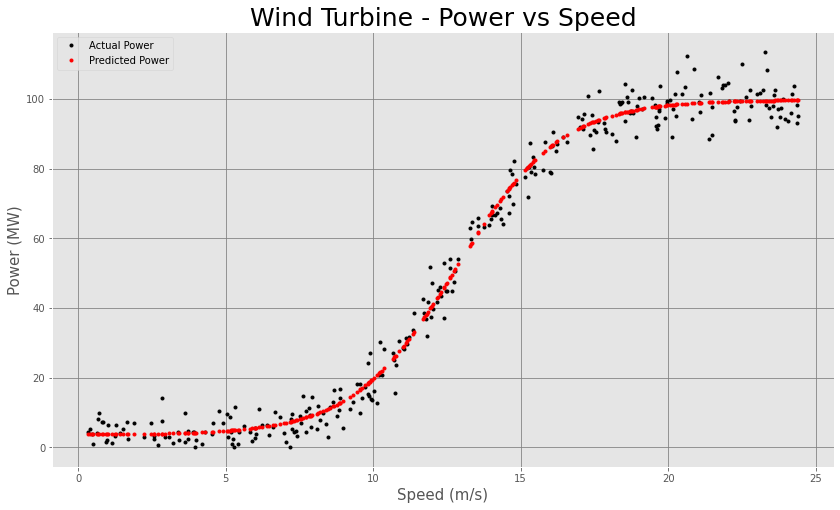

In [36]:
# Now let's see what the train dataset looks like for both the actual data and the predicted values from the model
plt.plot(X_train, y_train, 'k.', label='Actual Power')
plt.plot(X_train, model.predict(X_train), 'r.', label='Predicted Power')
plt.title('Wind Turbine - Power vs Speed', size=25)
plt.xlabel('Speed (m/s)', size=15)
plt.ylabel('Power (MW)', size=15)
# Show grid lines
plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.legend()

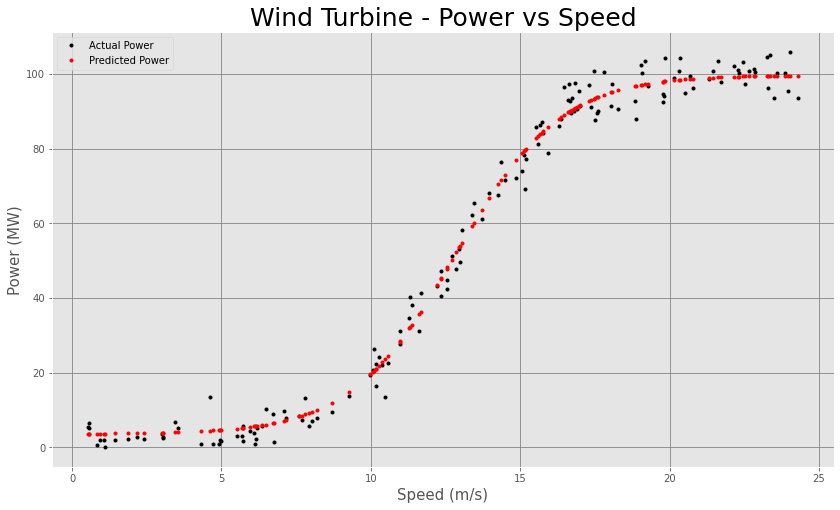

In [37]:
# The ultimate test is how the test dataset fits to its predicted reusults
# Now let's see how the test sample actual and predicted results compare, using the trained model
plt.plot(X_test, y_test, 'k.', label='Actual Power')
plt.plot(X_test, model.predict(X_test), 'r.', label='Predicted Power')
plt.title('Wind Turbine - Power vs Speed', size=25)
plt.xlabel('Speed (m/s)', size=15)
plt.ylabel('Power (MW)', size=15)
# Show grid lines
plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.legend()

In [38]:
# Evaluate the neural network on the test data.
model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 2ms/step - loss: 14.4214


14.421412467956543

In [39]:
y_pred = model.predict(X_test)

In [40]:
y_test.shape = (-1,1)

In [41]:
# Using the R-squared, we can measure the accuracy of the Nueral network using the test dataset
Rsquared = r2_score(y_test, y_pred)
print('R-squared: %.5f' %Rsquared)

R-squared: 0.99113


### 5.3 - Test model consisting of: 2 neurons 5000 epochs, batch size=10

![2-neurons](Images/2-neurons.JPG)<br><p style='text-align: right;'>(http://alexlenail.me/NN-SVG/index.html, 2020)</p>

We will build a model consisting of 2 neurons in the hidden layer

In [42]:
# Build a model using Keras
model = kr.models.Sequential()
# Change the hidden layer from 1 neuron to 2 neurons
model.add(kr.layers.Dense(2, input_shape=(1,), activation='sigmoid', kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform"))
model.add(kr.layers.Dense(1, activation='linear', kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform"))
model.compile(kr.optimizers.Adam(lr=0.001), loss='mean_squared_error')

In [43]:
# Fit the training dataset to the above model and run 5000 epochs in batches of 10 at a time.
model.fit(X_train, y_train, epochs=5000, batch_size=10)

Epoch 1/5000
31/31 [==============================] - 0s 868us/step - loss: 4586.1765
Epoch 2/5000
31/31 [==============================] - 0s 1ms/step - loss: 4506.8601
Epoch 3/5000
31/31 [==============================] - 0s 966us/step - loss: 4132.7476
Epoch 4/5000
31/31 [==============================] - 0s 1ms/step - loss: 4264.0843
Epoch 5/5000
31/31 [==============================] - 0s 1ms/step - loss: 4211.7730
Epoch 6/5000
31/31 [==============================] - 0s 1ms/step - loss: 4368.0833
Epoch 7/5000
31/31 [==============================] - 0s 967us/step - loss: 4180.3217
Epoch 8/5000
31/31 [==============================] - 0s 1ms/step - loss: 4668.8963
Epoch 9/5000
31/31 [==============================] - 0s 1ms/step - loss: 4387.1141
Epoch 10/5000
31/31 [==============================] - 0s 1ms/step - loss: 4440.5771
Epoch 11/5000
31/31 [==============================] - 0s 1ms/step - loss: 4277.9651
Epoch 12/5000
31/31 [==============================] - 0s 900us/step

31/31 [==============================] - 0s 933us/step - loss: 3837.6342
Epoch 97/5000
31/31 [==============================] - 0s 867us/step - loss: 3852.5459
Epoch 98/5000
31/31 [==============================] - 0s 1000us/step - loss: 3402.3382
Epoch 99/5000
31/31 [==============================] - 0s 968us/step - loss: 3457.8747
Epoch 100/5000
31/31 [==============================] - 0s 1000us/step - loss: 3569.4644
Epoch 101/5000
31/31 [==============================] - 0s 843us/step - loss: 3958.8542
Epoch 102/5000
31/31 [==============================] - 0s 861us/step - loss: 3819.7018
Epoch 103/5000
31/31 [==============================] - 0s 932us/step - loss: 3437.5510
Epoch 104/5000
31/31 [==============================] - 0s 900us/step - loss: 3285.2918
Epoch 105/5000
31/31 [==============================] - 0s 967us/step - loss: 3406.4425
Epoch 106/5000
31/31 [==============================] - 0s 967us/step - loss: 3750.7882
Epoch 107/5000
31/31 [==========================

31/31 [==============================] - 0s 934us/step - loss: 2206.7916
Epoch 283/5000
31/31 [==============================] - 0s 1ms/step - loss: 2336.6912
Epoch 284/5000
31/31 [==============================] - 0s 933us/step - loss: 2379.2379
Epoch 285/5000
31/31 [==============================] - 0s 967us/step - loss: 2395.7822
Epoch 286/5000
31/31 [==============================] - 0s 966us/step - loss: 2253.4459
Epoch 287/5000
31/31 [==============================] - 0s 841us/step - loss: 2214.9530
Epoch 288/5000
31/31 [==============================] - 0s 800us/step - loss: 2232.6849
Epoch 289/5000
31/31 [==============================] - 0s 966us/step - loss: 2411.0523
Epoch 290/5000
31/31 [==============================] - 0s 933us/step - loss: 2268.9359
Epoch 291/5000
31/31 [==============================] - 0s 933us/step - loss: 2387.6961
Epoch 292/5000
31/31 [==============================] - 0s 932us/step - loss: 2206.3857
Epoch 293/5000
31/31 [===========================

31/31 [==============================] - 0s 967us/step - loss: 1544.0738
Epoch 469/5000
31/31 [==============================] - 0s 967us/step - loss: 1400.6746
Epoch 470/5000
31/31 [==============================] - 0s 900us/step - loss: 1375.5945
Epoch 471/5000
31/31 [==============================] - 0s 933us/step - loss: 1394.1708
Epoch 472/5000
31/31 [==============================] - 0s 867us/step - loss: 1400.3913
Epoch 473/5000
31/31 [==============================] - 0s 933us/step - loss: 1402.3562
Epoch 474/5000
31/31 [==============================] - 0s 833us/step - loss: 1420.3667
Epoch 475/5000
31/31 [==============================] - 0s 867us/step - loss: 1426.9676
Epoch 476/5000
31/31 [==============================] - 0s 1000us/step - loss: 1359.0709
Epoch 477/5000
31/31 [==============================] - 0s 967us/step - loss: 1539.2170
Epoch 478/5000
31/31 [==============================] - 0s 967us/step - loss: 1546.1800
Epoch 479/5000
31/31 [========================

31/31 [==============================] - 0s 833us/step - loss: 903.1985
Epoch 656/5000
31/31 [==============================] - 0s 799us/step - loss: 824.5665
Epoch 657/5000
31/31 [==============================] - 0s 998us/step - loss: 843.1235
Epoch 658/5000
31/31 [==============================] - 0s 968us/step - loss: 815.3195
Epoch 659/5000
31/31 [==============================] - 0s 967us/step - loss: 806.6673
Epoch 660/5000
31/31 [==============================] - 0s 867us/step - loss: 859.2754
Epoch 661/5000
31/31 [==============================] - 0s 967us/step - loss: 778.4557
Epoch 662/5000
31/31 [==============================] - 0s 867us/step - loss: 823.8254
Epoch 663/5000
31/31 [==============================] - 0s 900us/step - loss: 810.1528
Epoch 664/5000
31/31 [==============================] - 0s 833us/step - loss: 722.2892
Epoch 665/5000
31/31 [==============================] - 0s 933us/step - loss: 832.4592
Epoch 666/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 867us/step - loss: 475.8387
Epoch 844/5000
31/31 [==============================] - 0s 1ms/step - loss: 435.8210
Epoch 845/5000
31/31 [==============================] - 0s 967us/step - loss: 446.0071
Epoch 846/5000
31/31 [==============================] - 0s 892us/step - loss: 433.3567
Epoch 847/5000
31/31 [==============================] - 0s 1ms/step - loss: 457.8326
Epoch 848/5000
31/31 [==============================] - 0s 935us/step - loss: 439.7332
Epoch 849/5000
31/31 [==============================] - 0s 901us/step - loss: 432.3651
Epoch 850/5000
31/31 [==============================] - 0s 933us/step - loss: 434.2082
Epoch 851/5000
31/31 [==============================] - 0s 951us/step - loss: 409.7883
Epoch 852/5000
31/31 [==============================] - 0s 1ms/step - loss: 455.9656
Epoch 853/5000
31/31 [==============================] - 0s 867us/step - loss: 405.5960
Epoch 854/5000
31/31 [==============================] - 0s 830us

31/31 [==============================] - 0s 967us/step - loss: 270.3489
Epoch 1032/5000
31/31 [==============================] - 0s 967us/step - loss: 238.5178
Epoch 1033/5000
31/31 [==============================] - 0s 901us/step - loss: 242.2125
Epoch 1034/5000
31/31 [==============================] - 0s 901us/step - loss: 231.9568
Epoch 1035/5000
31/31 [==============================] - 0s 967us/step - loss: 231.5817
Epoch 1036/5000
31/31 [==============================] - 0s 1ms/step - loss: 236.1657
Epoch 1037/5000
31/31 [==============================] - 0s 1ms/step - loss: 248.2974
Epoch 1038/5000
31/31 [==============================] - 0s 897us/step - loss: 235.1908
Epoch 1039/5000
31/31 [==============================] - 0s 967us/step - loss: 251.4381
Epoch 1040/5000
31/31 [==============================] - 0s 1ms/step - loss: 242.3558
Epoch 1041/5000
31/31 [==============================] - 0s 900us/step - loss: 227.5082
Epoch 1042/5000
31/31 [==============================]

31/31 [==============================] - 0s 865us/step - loss: 146.6167
Epoch 1218/5000
31/31 [==============================] - 0s 933us/step - loss: 137.5522
Epoch 1219/5000
31/31 [==============================] - 0s 967us/step - loss: 148.5835
Epoch 1220/5000
31/31 [==============================] - 0s 966us/step - loss: 136.8860
Epoch 1221/5000
31/31 [==============================] - 0s 1ms/step - loss: 142.9841
Epoch 1222/5000
31/31 [==============================] - 0s 999us/step - loss: 136.3758
Epoch 1223/5000
31/31 [==============================] - 0s 901us/step - loss: 138.1097
Epoch 1224/5000
31/31 [==============================] - 0s 1ms/step - loss: 143.0845
Epoch 1225/5000
31/31 [==============================] - 0s 899us/step - loss: 137.9984
Epoch 1226/5000
31/31 [==============================] - 0s 833us/step - loss: 138.9404
Epoch 1227/5000
31/31 [==============================] - 0s 900us/step - loss: 138.4817
Epoch 1228/5000
31/31 [=============================

31/31 [==============================] - 0s 933us/step - loss: 74.7720
Epoch 1405/5000
31/31 [==============================] - 0s 1ms/step - loss: 84.5993
Epoch 1406/5000
31/31 [==============================] - 0s 900us/step - loss: 82.4246
Epoch 1407/5000
31/31 [==============================] - 0s 1ms/step - loss: 84.2165
Epoch 1408/5000
31/31 [==============================] - 0s 1ms/step - loss: 81.1499
Epoch 1409/5000
31/31 [==============================] - 0s 1ms/step - loss: 81.9722
Epoch 1410/5000
31/31 [==============================] - 0s 1ms/step - loss: 81.2230
Epoch 1411/5000
31/31 [==============================] - 0s 1ms/step - loss: 78.9736
Epoch 1412/5000
31/31 [==============================] - 0s 1ms/step - loss: 79.5039
Epoch 1413/5000
31/31 [==============================] - 0s 1ms/step - loss: 78.9999
Epoch 1414/5000
31/31 [==============================] - 0s 1ms/step - loss: 81.4742
Epoch 1415/5000
31/31 [==============================] - 0s 833us/step - loss

31/31 [==============================] - 0s 881us/step - loss: 47.2095
Epoch 1593/5000
31/31 [==============================] - 0s 1ms/step - loss: 49.7421
Epoch 1594/5000
31/31 [==============================] - 0s 933us/step - loss: 44.0575
Epoch 1595/5000
31/31 [==============================] - 0s 967us/step - loss: 45.3581
Epoch 1596/5000
31/31 [==============================] - 0s 929us/step - loss: 49.1790
Epoch 1597/5000
31/31 [==============================] - 0s 999us/step - loss: 50.5457
Epoch 1598/5000
31/31 [==============================] - 0s 969us/step - loss: 48.1466
Epoch 1599/5000
31/31 [==============================] - 0s 1ms/step - loss: 42.3345
Epoch 1600/5000
31/31 [==============================] - 0s 1ms/step - loss: 46.5230
Epoch 1601/5000
31/31 [==============================] - 0s 968us/step - loss: 51.2504
Epoch 1602/5000
31/31 [==============================] - 0s 899us/step - loss: 43.5009
Epoch 1603/5000
31/31 [==============================] - 0s 1ms/s

Epoch 1687/5000
31/31 [==============================] - 0s 1ms/step - loss: 33.3802
Epoch 1688/5000
31/31 [==============================] - 0s 945us/step - loss: 33.3842
Epoch 1689/5000
31/31 [==============================] - 0s 1ms/step - loss: 35.3709
Epoch 1690/5000
31/31 [==============================] - 0s 800us/step - loss: 38.0309
Epoch 1691/5000
31/31 [==============================] - 0s 966us/step - loss: 35.4231
Epoch 1692/5000
31/31 [==============================] - 0s 858us/step - loss: 33.7710
Epoch 1693/5000
31/31 [==============================] - 0s 900us/step - loss: 34.4917
Epoch 1694/5000
31/31 [==============================] - 0s 1ms/step - loss: 36.7708
Epoch 1695/5000
31/31 [==============================] - 0s 1000us/step - loss: 29.9299
Epoch 1696/5000
31/31 [==============================] - 0s 1000us/step - loss: 32.8754
Epoch 1697/5000
31/31 [==============================] - 0s 1000us/step - loss: 34.6694
Epoch 1698/5000
31/31 [=======================

31/31 [==============================] - 0s 933us/step - loss: 25.2956
Epoch 1876/5000
31/31 [==============================] - 0s 933us/step - loss: 22.5039
Epoch 1877/5000
31/31 [==============================] - 0s 1000us/step - loss: 22.4866
Epoch 1878/5000
31/31 [==============================] - 0s 967us/step - loss: 21.9629
Epoch 1879/5000
31/31 [==============================] - 0s 932us/step - loss: 25.7144
Epoch 1880/5000
31/31 [==============================] - 0s 900us/step - loss: 24.5957
Epoch 1881/5000
31/31 [==============================] - 0s 1ms/step - loss: 20.8897
Epoch 1882/5000
31/31 [==============================] - 0s 867us/step - loss: 21.6034
Epoch 1883/5000
31/31 [==============================] - 0s 967us/step - loss: 22.4492
Epoch 1884/5000
31/31 [==============================] - 0s 833us/step - loss: 22.2792
Epoch 1885/5000
31/31 [==============================] - 0s 833us/step - loss: 24.5613
Epoch 1886/5000
31/31 [==============================] - 0s 

31/31 [==============================] - 0s 967us/step - loss: 19.3206
Epoch 2064/5000
31/31 [==============================] - 0s 933us/step - loss: 19.6170
Epoch 2065/5000
31/31 [==============================] - 0s 865us/step - loss: 18.2444
Epoch 2066/5000
31/31 [==============================] - 0s 865us/step - loss: 19.3305
Epoch 2067/5000
31/31 [==============================] - 0s 967us/step - loss: 18.6441
Epoch 2068/5000
31/31 [==============================] - 0s 1ms/step - loss: 19.2592
Epoch 2069/5000
31/31 [==============================] - 0s 933us/step - loss: 19.9617
Epoch 2070/5000
31/31 [==============================] - 0s 933us/step - loss: 22.3077
Epoch 2071/5000
31/31 [==============================] - 0s 967us/step - loss: 21.5379
Epoch 2072/5000
31/31 [==============================] - 0s 971us/step - loss: 18.9277
Epoch 2073/5000
31/31 [==============================] - 0s 859us/step - loss: 18.7527
Epoch 2074/5000
31/31 [==============================] - 0s 1

31/31 [==============================] - 0s 935us/step - loss: 15.8373
Epoch 2252/5000
31/31 [==============================] - 0s 1ms/step - loss: 20.2136
Epoch 2253/5000
31/31 [==============================] - 0s 967us/step - loss: 16.3223
Epoch 2254/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.4280
Epoch 2255/5000
31/31 [==============================] - 0s 900us/step - loss: 17.9903
Epoch 2256/5000
31/31 [==============================] - 0s 867us/step - loss: 17.8074
Epoch 2257/5000
31/31 [==============================] - 0s 933us/step - loss: 19.8557
Epoch 2258/5000
31/31 [==============================] - 0s 933us/step - loss: 16.4296
Epoch 2259/5000
31/31 [==============================] - 0s 867us/step - loss: 18.5496
Epoch 2260/5000
31/31 [==============================] - 0s 933us/step - loss: 17.6795
Epoch 2261/5000
31/31 [==============================] - 0s 833us/step - loss: 19.9324
Epoch 2262/5000
31/31 [==============================] - 0s 850

31/31 [==============================] - 0s 967us/step - loss: 18.2658
Epoch 2440/5000
31/31 [==============================] - 0s 933us/step - loss: 20.6753
Epoch 2441/5000
31/31 [==============================] - 0s 967us/step - loss: 18.4321
Epoch 2442/5000
31/31 [==============================] - 0s 966us/step - loss: 15.8476
Epoch 2443/5000
31/31 [==============================] - 0s 1ms/step - loss: 19.6749
Epoch 2444/5000
31/31 [==============================] - 0s 968us/step - loss: 18.7816
Epoch 2445/5000
31/31 [==============================] - 0s 900us/step - loss: 17.4612
Epoch 2446/5000
31/31 [==============================] - 0s 833us/step - loss: 19.8134
Epoch 2447/5000
31/31 [==============================] - 0s 800us/step - loss: 17.3050
Epoch 2448/5000
31/31 [==============================] - 0s 934us/step - loss: 19.0953
Epoch 2449/5000
31/31 [==============================] - 0s 1000us/step - loss: 19.2051
Epoch 2450/5000
31/31 [==============================] - 0s 

31/31 [==============================] - 0s 967us/step - loss: 18.2836
Epoch 2628/5000
31/31 [==============================] - 0s 935us/step - loss: 18.6893
Epoch 2629/5000
31/31 [==============================] - 0s 968us/step - loss: 18.0746
Epoch 2630/5000
31/31 [==============================] - 0s 902us/step - loss: 19.1660
Epoch 2631/5000
31/31 [==============================] - 0s 1000us/step - loss: 16.6432
Epoch 2632/5000
31/31 [==============================] - 0s 922us/step - loss: 18.1788
Epoch 2633/5000
31/31 [==============================] - 0s 1ms/step - loss: 19.8818
Epoch 2634/5000
31/31 [==============================] - 0s 876us/step - loss: 16.2470
Epoch 2635/5000
31/31 [==============================] - 0s 1ms/step - loss: 20.6796
Epoch 2636/5000
31/31 [==============================] - 0s 884us/step - loss: 21.1144
Epoch 2637/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.8780
Epoch 2638/5000
31/31 [==============================] - 0s 1000

31/31 [==============================] - 0s 933us/step - loss: 18.3918
Epoch 2816/5000
31/31 [==============================] - 0s 866us/step - loss: 19.1812
Epoch 2817/5000
31/31 [==============================] - 0s 933us/step - loss: 21.5686
Epoch 2818/5000
31/31 [==============================] - 0s 900us/step - loss: 17.1502
Epoch 2819/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.8495
Epoch 2820/5000
31/31 [==============================] - 0s 834us/step - loss: 18.2983
Epoch 2821/5000
31/31 [==============================] - 0s 933us/step - loss: 19.5230
Epoch 2822/5000
31/31 [==============================] - 0s 800us/step - loss: 18.4322
Epoch 2823/5000
31/31 [==============================] - 0s 967us/step - loss: 19.3903
Epoch 2824/5000
31/31 [==============================] - 0s 933us/step - loss: 16.7481
Epoch 2825/5000
31/31 [==============================] - 0s 901us/step - loss: 15.8411
Epoch 2826/5000
31/31 [==============================] - 0s 9

31/31 [==============================] - 0s 901us/step - loss: 20.7292
Epoch 3004/5000
31/31 [==============================] - 0s 933us/step - loss: 20.1394
Epoch 3005/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.1306
Epoch 3006/5000
31/31 [==============================] - 0s 933us/step - loss: 20.8082
Epoch 3007/5000
31/31 [==============================] - 0s 967us/step - loss: 17.2270
Epoch 3008/5000
31/31 [==============================] - 0s 966us/step - loss: 17.7872
Epoch 3009/5000
31/31 [==============================] - 0s 1ms/step - loss: 19.8445
Epoch 3010/5000
31/31 [==============================] - 0s 1000us/step - loss: 15.6892
Epoch 3011/5000
31/31 [==============================] - 0s 967us/step - loss: 17.5825
Epoch 3012/5000
31/31 [==============================] - 0s 1000us/step - loss: 18.6862
Epoch 3013/5000
31/31 [==============================] - 0s 967us/step - loss: 17.9596
Epoch 3014/5000
31/31 [==============================] - 0s 9

31/31 [==============================] - 0s 967us/step - loss: 16.1353
Epoch 3192/5000
31/31 [==============================] - 0s 933us/step - loss: 20.0175
Epoch 3193/5000
31/31 [==============================] - 0s 933us/step - loss: 17.6594
Epoch 3194/5000
31/31 [==============================] - 0s 900us/step - loss: 17.5389
Epoch 3195/5000
31/31 [==============================] - 0s 867us/step - loss: 18.9432
Epoch 3196/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.0584
Epoch 3197/5000
31/31 [==============================] - 0s 867us/step - loss: 19.1710
Epoch 3198/5000
31/31 [==============================] - 0s 933us/step - loss: 19.0656
Epoch 3199/5000
31/31 [==============================] - 0s 866us/step - loss: 18.4065
Epoch 3200/5000
31/31 [==============================] - 0s 833us/step - loss: 18.5747
Epoch 3201/5000
31/31 [==============================] - 0s 760us/step - loss: 17.1966
Epoch 3202/5000
31/31 [==============================] - 0s 9

31/31 [==============================] - 0s 966us/step - loss: 18.7969
Epoch 3380/5000
31/31 [==============================] - 0s 934us/step - loss: 17.5894
Epoch 3381/5000
31/31 [==============================] - 0s 933us/step - loss: 21.8373
Epoch 3382/5000
31/31 [==============================] - 0s 767us/step - loss: 17.8717
Epoch 3383/5000
31/31 [==============================] - 0s 965us/step - loss: 19.0704
Epoch 3384/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.1908
Epoch 3385/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.3409
Epoch 3386/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.3106
Epoch 3387/5000
31/31 [==============================] - 0s 933us/step - loss: 16.8012
Epoch 3388/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.4487
Epoch 3389/5000
31/31 [==============================] - 0s 848us/step - loss: 22.1131
Epoch 3390/5000
31/31 [==============================] - 0s 967us/s

31/31 [==============================] - 0s 934us/step - loss: 19.2682
Epoch 3568/5000
31/31 [==============================] - 0s 932us/step - loss: 16.4559
Epoch 3569/5000
31/31 [==============================] - 0s 933us/step - loss: 16.7556
Epoch 3570/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.6360
Epoch 3571/5000
31/31 [==============================] - 0s 967us/step - loss: 17.4655
Epoch 3572/5000
31/31 [==============================] - 0s 900us/step - loss: 17.1096
Epoch 3573/5000
31/31 [==============================] - 0s 833us/step - loss: 19.0121
Epoch 3574/5000
31/31 [==============================] - 0s 803us/step - loss: 20.0408
Epoch 3575/5000
31/31 [==============================] - 0s 967us/step - loss: 18.6978
Epoch 3576/5000
31/31 [==============================] - 0s 933us/step - loss: 17.3135
Epoch 3577/5000
31/31 [==============================] - 0s 833us/step - loss: 15.9659
Epoch 3578/5000
31/31 [==============================] - 0s 1

31/31 [==============================] - 0s 900us/step - loss: 20.0601
Epoch 3756/5000
31/31 [==============================] - 0s 900us/step - loss: 19.7322
Epoch 3757/5000
31/31 [==============================] - 0s 967us/step - loss: 18.7126
Epoch 3758/5000
31/31 [==============================] - 0s 966us/step - loss: 16.8362
Epoch 3759/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.2552
Epoch 3760/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.6009
Epoch 3761/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.6256
Epoch 3762/5000
31/31 [==============================] - 0s 935us/step - loss: 16.7917
Epoch 3763/5000
31/31 [==============================] - 0s 902us/step - loss: 21.4826
Epoch 3764/5000
31/31 [==============================] - 0s 833us/step - loss: 15.5170
Epoch 3765/5000
31/31 [==============================] - 0s 1000us/step - loss: 17.5715
Epoch 3766/5000
31/31 [==============================] - 0s 1ms/

31/31 [==============================] - 0s 1ms/step - loss: 17.4234
Epoch 3944/5000
31/31 [==============================] - 0s 1ms/step - loss: 20.4866
Epoch 3945/5000
31/31 [==============================] - 0s 1000us/step - loss: 15.2466
Epoch 3946/5000
31/31 [==============================] - 0s 1ms/step - loss: 19.5730
Epoch 3947/5000
31/31 [==============================] - 0s 1000us/step - loss: 18.9684
Epoch 3948/5000
31/31 [==============================] - 0s 967us/step - loss: 18.7499
Epoch 3949/5000
31/31 [==============================] - 0s 900us/step - loss: 19.6487
Epoch 3950/5000
31/31 [==============================] - 0s 1000us/step - loss: 16.6597
Epoch 3951/5000
31/31 [==============================] - 0s 967us/step - loss: 18.2769
Epoch 3952/5000
31/31 [==============================] - 0s 1000us/step - loss: 16.6220
Epoch 3953/5000
31/31 [==============================] - 0s 933us/step - loss: 17.9078
Epoch 3954/5000
31/31 [==============================] - 0s 9

31/31 [==============================] - 0s 935us/step - loss: 17.5394
Epoch 4133/5000
31/31 [==============================] - 0s 934us/step - loss: 18.2668
Epoch 4134/5000
31/31 [==============================] - 0s 967us/step - loss: 17.2740
Epoch 4135/5000
31/31 [==============================] - 0s 1000us/step - loss: 16.1178
Epoch 4136/5000
31/31 [==============================] - 0s 967us/step - loss: 17.6958
Epoch 4137/5000
31/31 [==============================] - 0s 967us/step - loss: 18.5682
Epoch 4138/5000
31/31 [==============================] - 0s 949us/step - loss: 17.0406
Epoch 4139/5000
31/31 [==============================] - 0s 867us/step - loss: 17.6389
Epoch 4140/5000
31/31 [==============================] - 0s 900us/step - loss: 16.7246
Epoch 4141/5000
31/31 [==============================] - 0s 967us/step - loss: 17.2782
Epoch 4142/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.8271
Epoch 4143/5000
31/31 [==============================] - 0s 

31/31 [==============================] - 0s 1000us/step - loss: 18.0779
Epoch 4321/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.5717
Epoch 4322/5000
31/31 [==============================] - 0s 1ms/step - loss: 15.7329
Epoch 4323/5000
31/31 [==============================] - 0s 901us/step - loss: 17.8170
Epoch 4324/5000
31/31 [==============================] - 0s 967us/step - loss: 17.5029
Epoch 4325/5000
31/31 [==============================] - 0s 933us/step - loss: 19.2145
Epoch 4326/5000
31/31 [==============================] - 0s 900us/step - loss: 18.3408
Epoch 4327/5000
31/31 [==============================] - 0s 967us/step - loss: 18.1654
Epoch 4328/5000
31/31 [==============================] - 0s 801us/step - loss: 20.1617
Epoch 4329/5000
31/31 [==============================] - 0s 843us/step - loss: 16.1287
Epoch 4330/5000
31/31 [==============================] - 0s 935us/step - loss: 16.4713
Epoch 4331/5000
31/31 [==============================] - 0s 1m

31/31 [==============================] - 0s 1ms/step - loss: 17.6932
Epoch 4509/5000
31/31 [==============================] - 0s 933us/step - loss: 17.5003
Epoch 4510/5000
31/31 [==============================] - 0s 967us/step - loss: 18.7067
Epoch 4511/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.6127
Epoch 4512/5000
31/31 [==============================] - 0s 1ms/step - loss: 23.0164
Epoch 4513/5000
31/31 [==============================] - 0s 1ms/step - loss: 19.5248
Epoch 4514/5000
31/31 [==============================] - 0s 1000us/step - loss: 18.5302
Epoch 4515/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.3503
Epoch 4516/5000
31/31 [==============================] - 0s 933us/step - loss: 18.8868
Epoch 4517/5000
31/31 [==============================] - 0s 866us/step - loss: 18.0556
Epoch 4518/5000
31/31 [==============================] - 0s 799us/step - loss: 20.2688
Epoch 4519/5000
31/31 [==============================] - 0s 933us/st

31/31 [==============================] - 0s 933us/step - loss: 16.9398
Epoch 4697/5000
31/31 [==============================] - 0s 967us/step - loss: 18.0691
Epoch 4698/5000
31/31 [==============================] - 0s 933us/step - loss: 16.7712
Epoch 4699/5000
31/31 [==============================] - 0s 933us/step - loss: 18.1133
Epoch 4700/5000
31/31 [==============================] - 0s 867us/step - loss: 16.2732
Epoch 4701/5000
31/31 [==============================] - 0s 865us/step - loss: 17.9563
Epoch 4702/5000
31/31 [==============================] - 0s 897us/step - loss: 17.6277
Epoch 4703/5000
31/31 [==============================] - 0s 1000us/step - loss: 18.1281
Epoch 4704/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.9186
Epoch 4705/5000
31/31 [==============================] - 0s 1000us/step - loss: 17.2975
Epoch 4706/5000
31/31 [==============================] - 0s 900us/step - loss: 18.7906
Epoch 4707/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 910us/step - loss: 15.6774
Epoch 4885/5000
31/31 [==============================] - 0s 867us/step - loss: 18.2980
Epoch 4886/5000
31/31 [==============================] - 0s 933us/step - loss: 16.3358
Epoch 4887/5000
31/31 [==============================] - 0s 866us/step - loss: 20.9399
Epoch 4888/5000
31/31 [==============================] - 0s 933us/step - loss: 19.3141
Epoch 4889/5000
31/31 [==============================] - 0s 833us/step - loss: 16.5549
Epoch 4890/5000
31/31 [==============================] - 0s 799us/step - loss: 18.1292
Epoch 4891/5000
31/31 [==============================] - 0s 1000us/step - loss: 16.5224
Epoch 4892/5000
31/31 [==============================] - 0s 967us/step - loss: 17.6063
Epoch 4893/5000
31/31 [==============================] - 0s 1000us/step - loss: 17.8072
Epoch 4894/5000
31/31 [==============================] - 0s 933us/step - loss: 15.3545
Epoch 4895/5000
31/31 [==============================] - 

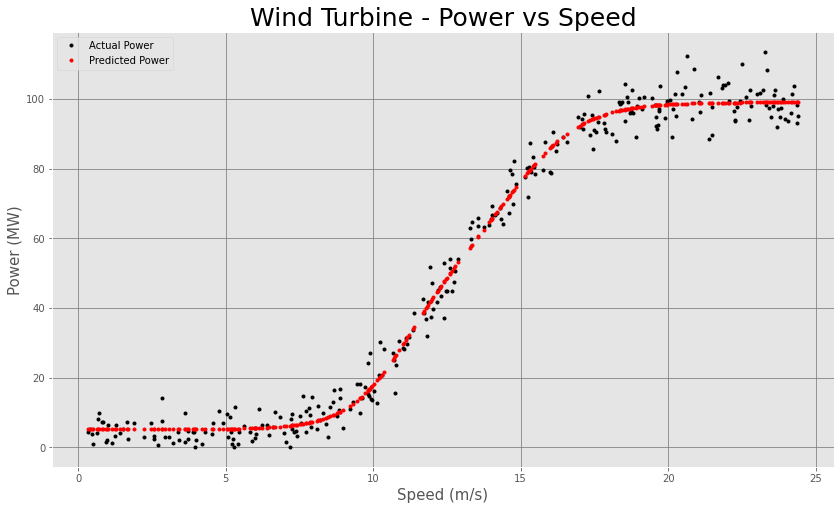

In [44]:
# Now let's see what the train dataset looks like for both the actual data and the predicted values from the model
plt.plot(X_train, y_train, 'k.', label='Actual Power')
plt.plot(X_train, model.predict(X_train), 'r.', label='Predicted Power')
plt.title('Wind Turbine - Power vs Speed', size=25)
plt.xlabel('Speed (m/s)', size=15)
plt.ylabel('Power (MW)', size=15)
# Show grid lines
plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.legend()

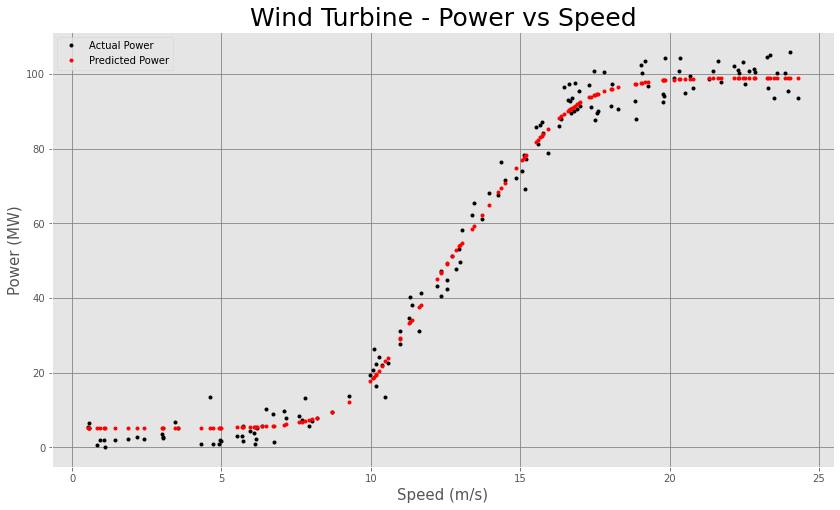

In [45]:
# The ultimate test is how the test dataset fits to its predicted reusults
# Now let's see how the test sample actual and predicted results compare, using the trained model
plt.plot(X_test, y_test, 'k.', label='Actual Power')
plt.plot(X_test, model.predict(X_test), 'r.', label='Predicted Power')
plt.title('Wind Turbine - Power vs Speed', size=25)
plt.xlabel('Speed (m/s)', size=15)
plt.ylabel('Power (MW)', size=15)
# Show grid lines
plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.legend()

In [46]:
# Evaluate the neural network on the test data.
model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 1ms/step - loss: 14.9997


14.999698638916016

In [47]:
y_pred = model.predict(X_test)

In [48]:
y_test.shape = (-1,1)

In [49]:
# Using the R-squared, we can measure the accuracy of the Nueral network using the test dataset
Rsquared = r2_score(y_test, y_pred)
print('R-squared: %.5f' %Rsquared)

R-squared: 0.99078


### 5.4 - Test model consisting of: 3 neurons 5000 epochs, batch size=10

![3-neurons](Images/3-neurons.JPG)<br><p style='text-align: right;'>(http://alexlenail.me/NN-SVG/index.html, 2020)</p>

Now, we will increase the model to 3 neurons in the hidden layer

In [50]:
# Build a model using Keras
model = kr.models.Sequential()
# Change the hidden layer from 2 neurons to 3 neurons
model.add(kr.layers.Dense(3, input_shape=(1,), activation='sigmoid', kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform"))
model.add(kr.layers.Dense(1, activation='linear', kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform"))
model.compile(kr.optimizers.Adam(lr=0.001), loss='mean_squared_error')

In [51]:
# Fit the training dataset to the above model and run 5000 epochs in batches of 10 at a time.
model.fit(X_train, y_train, epochs=5000, batch_size=10)

Epoch 1/5000
31/31 [==============================] - 0s 833us/step - loss: 5089.8893
Epoch 2/5000
31/31 [==============================] - 0s 1ms/step - loss: 4596.2092
Epoch 3/5000
31/31 [==============================] - 0s 1ms/step - loss: 4657.3287
Epoch 4/5000
31/31 [==============================] - 0s 1ms/step - loss: 4373.7612
Epoch 5/5000
31/31 [==============================] - 0s 1ms/step - loss: 4454.4842
Epoch 6/5000
31/31 [==============================] - 0s 1ms/step - loss: 4736.0419
Epoch 7/5000
31/31 [==============================] - 0s 967us/step - loss: 4638.7143
Epoch 8/5000
31/31 [==============================] - 0s 900us/step - loss: 4792.2870
Epoch 9/5000
31/31 [==============================] - 0s 1ms/step - loss: 4487.2021
Epoch 10/5000
31/31 [==============================] - 0s 1ms/step - loss: 4051.8791
Epoch 11/5000
31/31 [==============================] - 0s 867us/step - loss: 4518.0620
Epoch 12/5000
31/31 [==============================] - 0s 901us/st

Epoch 96/5000
31/31 [==============================] - 0s 933us/step - loss: 3629.6306
Epoch 97/5000
31/31 [==============================] - 0s 1ms/step - loss: 3542.4250
Epoch 98/5000
31/31 [==============================] - 0s 1ms/step - loss: 3657.1434
Epoch 99/5000
31/31 [==============================] - 0s 833us/step - loss: 3603.8704
Epoch 100/5000
31/31 [==============================] - 0s 1000us/step - loss: 3496.4504
Epoch 101/5000
31/31 [==============================] - 0s 1ms/step - loss: 3395.2938
Epoch 102/5000
31/31 [==============================] - 0s 1ms/step - loss: 3148.9475
Epoch 103/5000
31/31 [==============================] - 0s 1ms/step - loss: 3780.3944
Epoch 104/5000
31/31 [==============================] - 0s 1ms/step - loss: 3077.7384
Epoch 105/5000
31/31 [==============================] - 0s 1ms/step - loss: 3693.1445
Epoch 106/5000
31/31 [==============================] - 0s 928us/step - loss: 3240.0579
Epoch 107/5000
31/31 [===========================

31/31 [==============================] - 0s 1ms/step - loss: 3016.5283
Epoch 191/5000
31/31 [==============================] - 0s 1ms/step - loss: 2988.4068
Epoch 192/5000
31/31 [==============================] - 0s 1ms/step - loss: 2695.6033
Epoch 193/5000
31/31 [==============================] - 0s 900us/step - loss: 2911.6178
Epoch 194/5000
31/31 [==============================] - 0s 1000us/step - loss: 2865.5818
Epoch 195/5000
31/31 [==============================] - ETA: 0s - loss: 2765.48 - 0s 967us/step - loss: 3127.6032
Epoch 196/5000
31/31 [==============================] - 0s 867us/step - loss: 2883.7176
Epoch 197/5000
31/31 [==============================] - 0s 800us/step - loss: 2863.0278
Epoch 198/5000
31/31 [==============================] - 0s 900us/step - loss: 2573.7163
Epoch 199/5000
31/31 [==============================] - 0s 867us/step - loss: 2789.6979
Epoch 200/5000
31/31 [==============================] - 0s 1ms/step - loss: 2897.0803
Epoch 201/5000
31/31 [======

31/31 [==============================] - 0s 1ms/step - loss: 1864.9404
Epoch 377/5000
31/31 [==============================] - 0s 1ms/step - loss: 1776.4460
Epoch 378/5000
31/31 [==============================] - 0s 1ms/step - loss: 1807.6295
Epoch 379/5000
31/31 [==============================] - 0s 1ms/step - loss: 1814.5869
Epoch 380/5000
31/31 [==============================] - 0s 1ms/step - loss: 1886.4445
Epoch 381/5000
31/31 [==============================] - 0s 1ms/step - loss: 1738.5982
Epoch 382/5000
31/31 [==============================] - 0s 1ms/step - loss: 1697.6556
Epoch 383/5000
31/31 [==============================] - 0s 1ms/step - loss: 1947.7543
Epoch 384/5000
31/31 [==============================] - 0s 1ms/step - loss: 1711.3189
Epoch 385/5000
31/31 [==============================] - 0s 1ms/step - loss: 1826.7207
Epoch 386/5000
31/31 [==============================] - 0s 1ms/step - loss: 1922.8699
Epoch 387/5000
31/31 [==============================] - 0s 1ms/step -

31/31 [==============================] - 0s 1ms/step - loss: 932.9082
Epoch 564/5000
31/31 [==============================] - 0s 900us/step - loss: 1042.5001
Epoch 565/5000
31/31 [==============================] - 0s 933us/step - loss: 1055.3400
Epoch 566/5000
31/31 [==============================] - 0s 900us/step - loss: 1045.2143
Epoch 567/5000
31/31 [==============================] - 0s 1ms/step - loss: 993.3975
Epoch 568/5000
31/31 [==============================] - 0s 1000us/step - loss: 927.3530
Epoch 569/5000
31/31 [==============================] - 0s 867us/step - loss: 907.1046
Epoch 570/5000
31/31 [==============================] - 0s 933us/step - loss: 1046.6581
Epoch 571/5000
31/31 [==============================] - 0s 933us/step - loss: 1119.1592
Epoch 572/5000
31/31 [==============================] - 0s 833us/step - loss: 1036.5142
Epoch 573/5000
31/31 [==============================] - 0s 769us/step - loss: 984.9045
Epoch 574/5000
31/31 [==============================] -

31/31 [==============================] - 0s 1ms/step - loss: 491.9205
Epoch 752/5000
31/31 [==============================] - 0s 1ms/step - loss: 492.4089
Epoch 753/5000
31/31 [==============================] - 0s 1ms/step - loss: 462.1918
Epoch 754/5000
31/31 [==============================] - 0s 1ms/step - loss: 470.4597
Epoch 755/5000
31/31 [==============================] - 0s 833us/step - loss: 483.8982
Epoch 756/5000
31/31 [==============================] - 0s 900us/step - loss: 461.8263
Epoch 757/5000
31/31 [==============================] - 0s 933us/step - loss: 475.1531
Epoch 758/5000
31/31 [==============================] - 0s 1ms/step - loss: 437.9325
Epoch 759/5000
31/31 [==============================] - 0s 966us/step - loss: 477.4868
Epoch 760/5000
31/31 [==============================] - 0s 900us/step - loss: 471.6352
Epoch 761/5000
31/31 [==============================] - 0s 900us/step - loss: 440.4593
Epoch 762/5000
31/31 [==============================] - 0s 800us/ste

31/31 [==============================] - 0s 933us/step - loss: 168.4035
Epoch 940/5000
31/31 [==============================] - 0s 967us/step - loss: 158.1741
Epoch 941/5000
31/31 [==============================] - 0s 967us/step - loss: 166.3779
Epoch 942/5000
31/31 [==============================] - 0s 867us/step - loss: 170.1090
Epoch 943/5000
31/31 [==============================] - ETA: 0s - loss: 281.821 - 0s 933us/step - loss: 211.5814
Epoch 944/5000
31/31 [==============================] - 0s 833us/step - loss: 168.9932
Epoch 945/5000
31/31 [==============================] - 0s 900us/step - loss: 169.7363
Epoch 946/5000
31/31 [==============================] - 0s 1000us/step - loss: 150.2005
Epoch 947/5000
31/31 [==============================] - 0s 933us/step - loss: 183.7748
Epoch 948/5000
31/31 [==============================] - 0s 967us/step - loss: 170.6783
Epoch 949/5000
31/31 [==============================] - 0s 933us/step - loss: 165.5827
Epoch 950/5000
31/31 [=========

31/31 [==============================] - 0s 1ms/step - loss: 43.5728
Epoch 1127/5000
31/31 [==============================] - 0s 1000us/step - loss: 43.5799
Epoch 1128/5000
31/31 [==============================] - 0s 900us/step - loss: 37.7070
Epoch 1129/5000
31/31 [==============================] - 0s 944us/step - loss: 49.9820
Epoch 1130/5000
31/31 [==============================] - 0s 967us/step - loss: 50.3195
Epoch 1131/5000
31/31 [==============================] - 0s 835us/step - loss: 43.1156
Epoch 1132/5000
31/31 [==============================] - 0s 935us/step - loss: 49.9983
Epoch 1133/5000
31/31 [==============================] - 0s 883us/step - loss: 47.7912
Epoch 1134/5000
31/31 [==============================] - 0s 967us/step - loss: 38.4678
Epoch 1135/5000
31/31 [==============================] - 0s 950us/step - loss: 44.5847
Epoch 1136/5000
31/31 [==============================] - 0s 967us/step - loss: 41.9255
Epoch 1137/5000
31/31 [==============================] - 0s 

31/31 [==============================] - 0s 933us/step - loss: 18.6515
Epoch 1315/5000
31/31 [==============================] - 0s 867us/step - loss: 19.8582
Epoch 1316/5000
31/31 [==============================] - 0s 933us/step - loss: 18.4983
Epoch 1317/5000
31/31 [==============================] - 0s 900us/step - loss: 17.0932
Epoch 1318/5000
31/31 [==============================] - 0s 933us/step - loss: 19.0766
Epoch 1319/5000
31/31 [==============================] - 0s 933us/step - loss: 22.0286
Epoch 1320/5000
31/31 [==============================] - 0s 833us/step - loss: 16.7997
Epoch 1321/5000
31/31 [==============================] - 0s 967us/step - loss: 15.4815
Epoch 1322/5000
31/31 [==============================] - 0s 865us/step - loss: 16.1152
Epoch 1323/5000
31/31 [==============================] - 0s 933us/step - loss: 18.5512
Epoch 1324/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.8888
Epoch 1325/5000
31/31 [==============================] - 0s 9

31/31 [==============================] - 0s 1000us/step - loss: 16.5504
Epoch 1504/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.5588
Epoch 1505/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.1031
Epoch 1506/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9611
Epoch 1507/5000
31/31 [==============================] - 0s 933us/step - loss: 18.6131
Epoch 1508/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.7409
Epoch 1509/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.3307
Epoch 1510/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.7129
Epoch 1511/5000
31/31 [==============================] - 0s 1ms/step - loss: 19.5287
Epoch 1512/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.3416
Epoch 1513/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.2592
Epoch 1514/5000
31/31 [==============================] - 0s 1ms/step - loss:

31/31 [==============================] - 0s 966us/step - loss: 17.2515
Epoch 1694/5000
31/31 [==============================] - 0s 898us/step - loss: 20.2337
Epoch 1695/5000
31/31 [==============================] - 0s 999us/step - loss: 18.5803
Epoch 1696/5000
31/31 [==============================] - 0s 833us/step - loss: 18.3097
Epoch 1697/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.9367
Epoch 1698/5000
31/31 [==============================] - 0s 966us/step - loss: 18.5859
Epoch 1699/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.6353
Epoch 1700/5000
31/31 [==============================] - 0s 900us/step - loss: 16.5443
Epoch 1701/5000
31/31 [==============================] - 0s 800us/step - loss: 15.5296
Epoch 1702/5000
31/31 [==============================] - 0s 933us/step - loss: 15.6325
Epoch 1703/5000
31/31 [==============================] - 0s 933us/step - loss: 14.4886
Epoch 1704/5000
31/31 [==============================] - 0s 968

31/31 [==============================] - 0s 1ms/step - loss: 19.4266
Epoch 1789/5000
31/31 [==============================] - 0s 1ms/step - loss: 15.0053
Epoch 1790/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.1203
Epoch 1791/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.5144
Epoch 1792/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0370
Epoch 1793/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0596
Epoch 1794/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.1205
Epoch 1795/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0301
Epoch 1796/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0485
Epoch 1797/5000
31/31 [==============================] - 0s 1ms/step - loss: 19.6542
Epoch 1798/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.2295
Epoch 1799/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0

31/31 [==============================] - 0s 933us/step - loss: 17.4914
Epoch 1979/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.1988
Epoch 1980/5000
31/31 [==============================] - 0s 900us/step - loss: 17.0433
Epoch 1981/5000
31/31 [==============================] - 0s 900us/step - loss: 16.2845
Epoch 1982/5000
31/31 [==============================] - 0s 867us/step - loss: 19.1228
Epoch 1983/5000
31/31 [==============================] - 0s 1ms/step - loss: 20.5277
Epoch 1984/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.8885
Epoch 1985/5000
31/31 [==============================] - 0s 968us/step - loss: 14.4074
Epoch 1986/5000
31/31 [==============================] - 0s 900us/step - loss: 17.0769
Epoch 1987/5000
31/31 [==============================] - 0s 900us/step - loss: 17.6573
Epoch 1988/5000
31/31 [==============================] - 0s 867us/step - loss: 18.2136
Epoch 1989/5000
31/31 [==============================] - 0s 833us

Epoch 2168/5000
31/31 [==============================] - 0s 933us/step - loss: 17.4278
Epoch 2169/5000
31/31 [==============================] - 0s 867us/step - loss: 17.4738
Epoch 2170/5000
31/31 [==============================] - 0s 867us/step - loss: 16.9669
Epoch 2171/5000
31/31 [==============================] - 0s 900us/step - loss: 16.3485
Epoch 2172/5000
31/31 [==============================] - 0s 833us/step - loss: 17.5283
Epoch 2173/5000
31/31 [==============================] - 0s 799us/step - loss: 16.3196
Epoch 2174/5000
31/31 [==============================] - 0s 1ms/step - loss: 19.3052
Epoch 2175/5000
31/31 [==============================] - 0s 1ms/step - loss: 15.3669
Epoch 2176/5000
31/31 [==============================] - 0s 1ms/step - loss: 19.0719
Epoch 2177/5000
31/31 [==============================] - 0s 1ms/step - loss: 20.2425
Epoch 2178/5000
31/31 [==============================] - 0s 1ms/step - loss: 14.9921
Epoch 2179/5000
31/31 [==============================

31/31 [==============================] - 0s 900us/step - loss: 19.4486
Epoch 2358/5000
31/31 [==============================] - 0s 900us/step - loss: 15.7737
Epoch 2359/5000
31/31 [==============================] - 0s 1ms/step - loss: 19.3308
Epoch 2360/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.2947
Epoch 2361/5000
31/31 [==============================] - 0s 1ms/step - loss: 15.3710
Epoch 2362/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.6404
Epoch 2363/5000
31/31 [==============================] - 0s 1ms/step - loss: 19.6360
Epoch 2364/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.4080
Epoch 2365/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.0123
Epoch 2366/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.8870
Epoch 2367/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.4279
Epoch 2368/5000
31/31 [==============================] - 0s 1ms/step - loss: 

31/31 [==============================] - 0s 800us/step - loss: 17.6957
Epoch 2548/5000
31/31 [==============================] - 0s 867us/step - loss: 17.4748
Epoch 2549/5000
31/31 [==============================] - 0s 933us/step - loss: 16.5395
Epoch 2550/5000
31/31 [==============================] - 0s 1ms/step - loss: 20.2400
Epoch 2551/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.9056
Epoch 2552/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.2750
Epoch 2553/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.4774
Epoch 2554/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.7640
Epoch 2555/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.4085
Epoch 2556/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.1523
Epoch 2557/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.7881
Epoch 2558/5000
31/31 [==============================] - 0s 933us/step - lo

31/31 [==============================] - 0s 1000us/step - loss: 17.8821
Epoch 2737/5000
31/31 [==============================] - 0s 1000us/step - loss: 16.1906
Epoch 2738/5000
31/31 [==============================] - 0s 968us/step - loss: 14.0952
Epoch 2739/5000
31/31 [==============================] - 0s 967us/step - loss: 18.4088
Epoch 2740/5000
31/31 [==============================] - 0s 901us/step - loss: 19.3549
Epoch 2741/5000
31/31 [==============================] - 0s 800us/step - loss: 18.5778
Epoch 2742/5000
31/31 [==============================] - 0s 901us/step - loss: 20.6440
Epoch 2743/5000
31/31 [==============================] - 0s 932us/step - loss: 15.2008
Epoch 2744/5000
31/31 [==============================] - 0s 933us/step - loss: 16.7769
Epoch 2745/5000
31/31 [==============================] - 0s 932us/step - loss: 20.2189
Epoch 2746/5000
31/31 [==============================] - 0s 833us/step - loss: 19.4650
Epoch 2747/5000
31/31 [==============================] - 

31/31 [==============================] - 0s 1000us/step - loss: 17.0197
Epoch 2925/5000
31/31 [==============================] - 0s 967us/step - loss: 16.2811
Epoch 2926/5000
31/31 [==============================] - 0s 1000us/step - loss: 17.3217
Epoch 2927/5000
31/31 [==============================] - 0s 967us/step - loss: 18.4985
Epoch 2928/5000
31/31 [==============================] - 0s 1000us/step - loss: 18.6813
Epoch 2929/5000
31/31 [==============================] - 0s 834us/step - loss: 18.9814
Epoch 2930/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.0761
Epoch 2931/5000
31/31 [==============================] - 0s 900us/step - loss: 16.0562
Epoch 2932/5000
31/31 [==============================] - 0s 900us/step - loss: 17.8241
Epoch 2933/5000
31/31 [==============================] - 0s 867us/step - loss: 20.3485
Epoch 2934/5000
31/31 [==============================] - 0s 861us/step - loss: 16.4226
Epoch 2935/5000
31/31 [==============================] - 0

31/31 [==============================] - 0s 866us/step - loss: 17.6689
Epoch 3113/5000
31/31 [==============================] - 0s 916us/step - loss: 18.3249
Epoch 3114/5000
31/31 [==============================] - 0s 933us/step - loss: 14.9085
Epoch 3115/5000
31/31 [==============================] - 0s 900us/step - loss: 20.9956
Epoch 3116/5000
31/31 [==============================] - 0s 1ms/step - loss: 15.3929
Epoch 3117/5000
31/31 [==============================] - 0s 997us/step - loss: 18.2945
Epoch 3118/5000
31/31 [==============================] - 0s 933us/step - loss: 17.9979
Epoch 3119/5000
31/31 [==============================] - 0s 867us/step - loss: 16.1745
Epoch 3120/5000
31/31 [==============================] - 0s 854us/step - loss: 19.6250
Epoch 3121/5000
31/31 [==============================] - 0s 939us/step - loss: 18.4804
Epoch 3122/5000
31/31 [==============================] - 0s 1000us/step - loss: 16.6412
Epoch 3123/5000
31/31 [==============================] - 0s 

31/31 [==============================] - 0s 935us/step - loss: 16.3045
Epoch 3301/5000
31/31 [==============================] - 0s 900us/step - loss: 16.4067
Epoch 3302/5000
31/31 [==============================] - 0s 933us/step - loss: 17.4708
Epoch 3303/5000
31/31 [==============================] - 0s 867us/step - loss: 16.8179
Epoch 3304/5000
31/31 [==============================] - 0s 913us/step - loss: 16.3378
Epoch 3305/5000
31/31 [==============================] - 0s 967us/step - loss: 15.9161
Epoch 3306/5000
31/31 [==============================] - 0s 1ms/step - loss: 19.5193
Epoch 3307/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.7063
Epoch 3308/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.7333
Epoch 3309/5000
31/31 [==============================] - 0s 960us/step - loss: 17.3257
Epoch 3310/5000
31/31 [==============================] - 0s 967us/step - loss: 20.0736
Epoch 3311/5000
31/31 [==============================] - 0s 1ms/s

31/31 [==============================] - 0s 967us/step - loss: 18.7729
Epoch 3489/5000
31/31 [==============================] - 0s 900us/step - loss: 21.0986
Epoch 3490/5000
31/31 [==============================] - 0s 1000us/step - loss: 19.4855
Epoch 3491/5000
31/31 [==============================] - 0s 1000us/step - loss: 17.1710
Epoch 3492/5000
31/31 [==============================] - 0s 1000us/step - loss: 16.8935
Epoch 3493/5000
31/31 [==============================] - 0s 999us/step - loss: 19.1727
Epoch 3494/5000
31/31 [==============================] - 0s 986us/step - loss: 16.1802
Epoch 3495/5000
31/31 [==============================] - 0s 1ms/step - loss: 15.2577
Epoch 3496/5000
31/31 [==============================] - 0s 967us/step - loss: 18.5024
Epoch 3497/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.6213
Epoch 3498/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.5068
Epoch 3499/5000
31/31 [==============================] - 0s 86

31/31 [==============================] - 0s 1000us/step - loss: 17.3038
Epoch 3677/5000
31/31 [==============================] - 0s 900us/step - loss: 16.0866
Epoch 3678/5000
31/31 [==============================] - 0s 933us/step - loss: 19.7630
Epoch 3679/5000
31/31 [==============================] - 0s 833us/step - loss: 16.4504
Epoch 3680/5000
31/31 [==============================] - 0s 800us/step - loss: 16.8735
Epoch 3681/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.8252
Epoch 3682/5000
31/31 [==============================] - 0s 812us/step - loss: 16.1206
Epoch 3683/5000
31/31 [==============================] - 0s 1000us/step - loss: 18.0651
Epoch 3684/5000
31/31 [==============================] - 0s 968us/step - loss: 20.6679
Epoch 3685/5000
31/31 [==============================] - 0s 867us/step - loss: 17.9224
Epoch 3686/5000
31/31 [==============================] - 0s 867us/step - loss: 18.0394
Epoch 3687/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 1ms/step - loss: 18.8304
Epoch 3864/5000
31/31 [==============================] - 0s 900us/step - loss: 16.9658
Epoch 3865/5000
31/31 [==============================] - 0s 967us/step - loss: 17.7273
Epoch 3866/5000
31/31 [==============================] - 0s 933us/step - loss: 17.8430
Epoch 3867/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.3168
Epoch 3868/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.0059
Epoch 3869/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.2791
Epoch 3870/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9499
Epoch 3871/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.7268
Epoch 3872/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.4303
Epoch 3873/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.7120
Epoch 3874/5000
31/31 [==============================] - 0s 900us/step - lo

31/31 [==============================] - 0s 800us/step - loss: 17.3975
Epoch 4052/5000
31/31 [==============================] - 0s 867us/step - loss: 16.0827
Epoch 4053/5000
31/31 [==============================] - 0s 1ms/step - loss: 19.4031
Epoch 4054/5000
31/31 [==============================] - 0s 967us/step - loss: 16.0224
Epoch 4055/5000
31/31 [==============================] - 0s 933us/step - loss: 16.7849
Epoch 4056/5000
31/31 [==============================] - 0s 967us/step - loss: 17.1358
Epoch 4057/5000
31/31 [==============================] - 0s 967us/step - loss: 18.0324
Epoch 4058/5000
31/31 [==============================] - 0s 1ms/step - loss: 15.3705
Epoch 4059/5000
31/31 [==============================] - 0s 967us/step - loss: 18.1818
Epoch 4060/5000
31/31 [==============================] - 0s 933us/step - loss: 16.3061
Epoch 4061/5000
31/31 [==============================] - 0s 933us/step - loss: 16.2573
Epoch 4062/5000
31/31 [==============================] - 0s 833

31/31 [==============================] - 0s 967us/step - loss: 18.2209
Epoch 4240/5000
31/31 [==============================] - 0s 933us/step - loss: 17.5779
Epoch 4241/5000
31/31 [==============================] - 0s 867us/step - loss: 16.9154
Epoch 4242/5000
31/31 [==============================] - 0s 858us/step - loss: 15.8569
Epoch 4243/5000
31/31 [==============================] - 0s 899us/step - loss: 16.3320
Epoch 4244/5000
31/31 [==============================] - 0s 966us/step - loss: 17.8411
Epoch 4245/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.9778
Epoch 4246/5000
31/31 [==============================] - 0s 1000us/step - loss: 16.4070
Epoch 4247/5000
31/31 [==============================] - 0s 966us/step - loss: 17.2878
Epoch 4248/5000
31/31 [==============================] - 0s 965us/step - loss: 16.8932
Epoch 4249/5000
31/31 [==============================] - 0s 966us/step - loss: 18.9976
Epoch 4250/5000
31/31 [==============================] - 0s 

31/31 [==============================] - 0s 930us/step - loss: 17.3043
Epoch 4428/5000
31/31 [==============================] - 0s 933us/step - loss: 16.7567
Epoch 4429/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.8980
Epoch 4430/5000
31/31 [==============================] - 0s 1ms/step - loss: 19.1783
Epoch 4431/5000
31/31 [==============================] - 0s 1ms/step - loss: 19.2531
Epoch 4432/5000
31/31 [==============================] - 0s 933us/step - loss: 18.9501
Epoch 4433/5000
31/31 [==============================] - 0s 833us/step - loss: 17.2731
Epoch 4434/5000
31/31 [==============================] - 0s 867us/step - loss: 15.7406
Epoch 4435/5000
31/31 [==============================] - 0s 933us/step - loss: 17.8368
Epoch 4436/5000
31/31 [==============================] - 0s 1ms/step - loss: 19.0182
Epoch 4437/5000
31/31 [==============================] - 0s 933us/step - loss: 16.6838
Epoch 4438/5000
31/31 [==============================] - 0s 1000us/

31/31 [==============================] - 0s 933us/step - loss: 19.7805
Epoch 4616/5000
31/31 [==============================] - 0s 933us/step - loss: 17.7242
Epoch 4617/5000
31/31 [==============================] - 0s 967us/step - loss: 19.3647
Epoch 4618/5000
31/31 [==============================] - 0s 967us/step - loss: 15.1388
Epoch 4619/5000
31/31 [==============================] - 0s 1000us/step - loss: 16.5051
Epoch 4620/5000
31/31 [==============================] - 0s 933us/step - loss: 17.0641
Epoch 4621/5000
31/31 [==============================] - 0s 1ms/step - loss: 15.1268
Epoch 4622/5000
31/31 [==============================] - 0s 967us/step - loss: 17.6969
Epoch 4623/5000
31/31 [==============================] - 0s 933us/step - loss: 17.8915
Epoch 4624/5000
31/31 [==============================] - 0s 1000us/step - loss: 17.9836
Epoch 4625/5000
31/31 [==============================] - 0s 933us/step - loss: 19.4336
Epoch 4626/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 1ms/step - loss: 15.5638
Epoch 4804/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.1979
Epoch 4805/5000
31/31 [==============================] - 0s 1ms/step - loss: 14.6927
Epoch 4806/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.6762
Epoch 4807/5000
31/31 [==============================] - 0s 966us/step - loss: 16.5010
Epoch 4808/5000
31/31 [==============================] - 0s 966us/step - loss: 17.7386
Epoch 4809/5000
31/31 [==============================] - 0s 1000us/step - loss: 17.4660
Epoch 4810/5000
31/31 [==============================] - 0s 967us/step - loss: 16.3194
Epoch 4811/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.5223
Epoch 4812/5000
31/31 [==============================] - 0s 900us/step - loss: 17.5571
Epoch 4813/5000
31/31 [==============================] - 0s 800us/step - loss: 17.7257
Epoch 4814/5000
31/31 [==============================] - 0s 800us/st

31/31 [==============================] - 0s 967us/step - loss: 16.3501
Epoch 4992/5000
31/31 [==============================] - 0s 933us/step - loss: 17.2211
Epoch 4993/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.9164
Epoch 4994/5000
31/31 [==============================] - 0s 901us/step - loss: 18.7880
Epoch 4995/5000
31/31 [==============================] - 0s 1000us/step - loss: 16.6673
Epoch 4996/5000
31/31 [==============================] - 0s 967us/step - loss: 15.4125
Epoch 4997/5000
31/31 [==============================] - 0s 900us/step - loss: 17.5432
Epoch 4998/5000
31/31 [==============================] - 0s 933us/step - loss: 17.1514
Epoch 4999/5000
31/31 [==============================] - 0s 833us/step - loss: 15.8753
Epoch 5000/5000
31/31 [==============================] - 0s 897us/step - loss: 16.3042


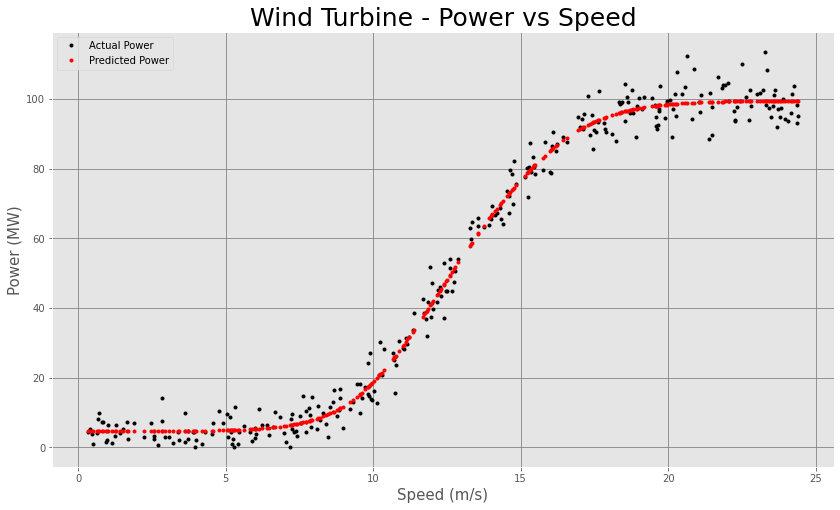

In [52]:
# Now let's see what the train dataset looks like for both the actual data and the predicted values from the model
plt.plot(X_train, y_train, 'k.', label='Actual Power')
plt.plot(X_train, model.predict(X_train), 'r.', label='Predicted Power')
plt.title('Wind Turbine - Power vs Speed', size=25)
plt.xlabel('Speed (m/s)', size=15)
plt.ylabel('Power (MW)', size=15)
# Show grid lines
plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.legend()

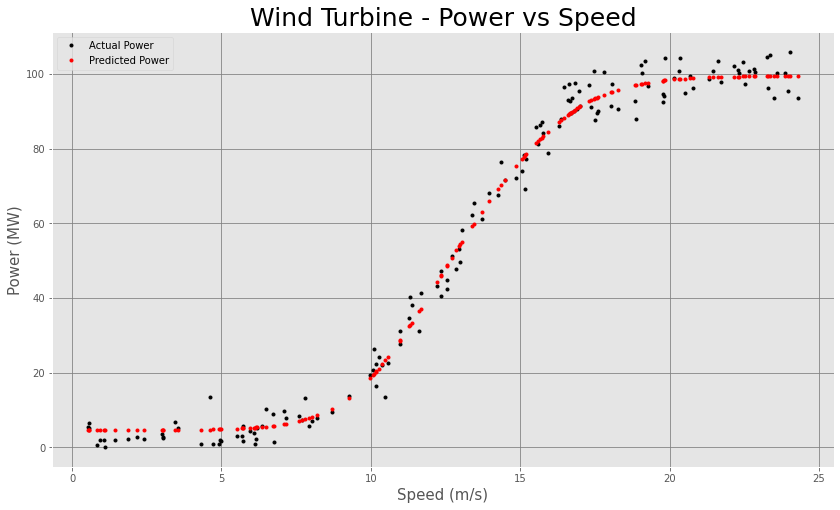

In [53]:
# The ultimate test is how the test dataset fits to its predicted reusults
# Now let's see how the test sample actual and predicted results compare, using the trained model
plt.plot(X_test, y_test, 'k.', label='Actual Power')
plt.plot(X_test, model.predict(X_test), 'r.', label='Predicted Power')
plt.title('Wind Turbine - Power vs Speed', size=25)
plt.xlabel('Speed (m/s)', size=15)
plt.ylabel('Power (MW)', size=15)
# Show grid lines
plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.legend()

In [54]:
# Evaluate the neural network on the test data.
model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 1ms/step - loss: 14.6595


14.659451484680176

In [55]:
y_pred = model.predict(X_test)

In [56]:
y_test.shape = (-1,1)

In [57]:
# Using the R-squared, we can measure the accuracy of the Nueral network using the test dataset
Rsquared = r2_score(y_test, y_pred)
print('R-squared: %.5f' %Rsquared)

R-squared: 0.99099


### 5.5 - Test model consisting of: 5 neurons 5000 epochs, batch size=10

![5-neurons](Images/5-neurons.JPG)<br><p style='text-align: right;'>(http://alexlenail.me/NN-SVG/index.html, 2020)</p>

Finally, we will look at a model with 5 neurons in the hidden layer

In [58]:
# Build a model using Keras
model = kr.models.Sequential()
# Change the hidden layer from 3 neurons to 5 neurons
model.add(kr.layers.Dense(5, input_shape=(1,), activation='sigmoid', kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform"))
model.add(kr.layers.Dense(1, activation='linear', kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform"))
model.compile(kr.optimizers.Adam(lr=0.001), loss='mean_squared_error')

In [59]:
# Fit the training dataset to the above model and run 5000 epochs in batches of 10 at a time.
model.fit(X_train, y_train, epochs=5000, batch_size=10)

Epoch 1/5000
31/31 [==============================] - 0s 868us/step - loss: 4536.2053
Epoch 2/5000
31/31 [==============================] - 0s 968us/step - loss: 4585.0322
Epoch 3/5000
31/31 [==============================] - 0s 900us/step - loss: 4577.0246
Epoch 4/5000
31/31 [==============================] - 0s 1ms/step - loss: 4356.2842
Epoch 5/5000
31/31 [==============================] - 0s 1ms/step - loss: 3952.8131
Epoch 6/5000
31/31 [==============================] - 0s 1ms/step - loss: 4313.5789
Epoch 7/5000
31/31 [==============================] - 0s 900us/step - loss: 4703.9712
Epoch 8/5000
31/31 [==============================] - 0s 1ms/step - loss: 4190.6265
Epoch 9/5000
31/31 [==============================] - 0s 1000us/step - loss: 4341.2459
Epoch 10/5000
31/31 [==============================] - 0s 1ms/step - loss: 4621.2812
Epoch 11/5000
31/31 [==============================] - 0s 900us/step - loss: 4424.1228
Epoch 12/5000
31/31 [==============================] - 0s 1ms

31/31 [==============================] - 0s 1ms/step - loss: 3149.2754
Epoch 97/5000
31/31 [==============================] - 0s 933us/step - loss: 3314.0782
Epoch 98/5000
31/31 [==============================] - 0s 900us/step - loss: 3133.8862
Epoch 99/5000
31/31 [==============================] - 0s 900us/step - loss: 3462.4018
Epoch 100/5000
31/31 [==============================] - 0s 1ms/step - loss: 2979.9618
Epoch 101/5000
31/31 [==============================] - 0s 1ms/step - loss: 3148.0857
Epoch 102/5000
31/31 [==============================] - 0s 1ms/step - loss: 2995.8110
Epoch 103/5000
31/31 [==============================] - 0s 1ms/step - loss: 3164.3906
Epoch 104/5000
31/31 [==============================] - 0s 1ms/step - loss: 3105.8153
Epoch 105/5000
31/31 [==============================] - 0s 1ms/step - loss: 3190.9740
Epoch 106/5000
31/31 [==============================] - 0s 967us/step - loss: 3013.0105
Epoch 107/5000
31/31 [==============================] - 0s 1000u

31/31 [==============================] - 0s 867us/step - loss: 1542.7180
Epoch 283/5000
31/31 [==============================] - 0s 901us/step - loss: 1451.6470
Epoch 284/5000
31/31 [==============================] - 0s 935us/step - loss: 1308.9257
Epoch 285/5000
31/31 [==============================] - 0s 935us/step - loss: 1569.3903
Epoch 286/5000
31/31 [==============================] - 0s 965us/step - loss: 1619.5394
Epoch 287/5000
31/31 [==============================] - 0s 867us/step - loss: 1415.3115
Epoch 288/5000
31/31 [==============================] - 0s 867us/step - loss: 1425.6033
Epoch 289/5000
31/31 [==============================] - 0s 907us/step - loss: 1432.5578
Epoch 290/5000
31/31 [==============================] - 0s 1000us/step - loss: 1344.1391
Epoch 291/5000
31/31 [==============================] - 0s 833us/step - loss: 1326.6103
Epoch 292/5000
31/31 [==============================] - 0s 967us/step - loss: 1518.1118
Epoch 293/5000
31/31 [========================

31/31 [==============================] - 0s 933us/step - loss: 467.9042
Epoch 470/5000
31/31 [==============================] - 0s 933us/step - loss: 544.8377
Epoch 471/5000
31/31 [==============================] - 0s 933us/step - loss: 545.3350
Epoch 472/5000
31/31 [==============================] - 0s 967us/step - loss: 512.8090
Epoch 473/5000
31/31 [==============================] - 0s 1000us/step - loss: 487.7207
Epoch 474/5000
31/31 [==============================] - 0s 967us/step - loss: 517.2326
Epoch 475/5000
31/31 [==============================] - 0s 825us/step - loss: 462.1308
Epoch 476/5000
31/31 [==============================] - 0s 933us/step - loss: 454.2715
Epoch 477/5000
31/31 [==============================] - 0s 867us/step - loss: 503.4773
Epoch 478/5000
31/31 [==============================] - 0s 804us/step - loss: 427.3536
Epoch 479/5000
31/31 [==============================] - 0s 900us/step - loss: 478.6172
Epoch 480/5000
31/31 [==============================] - 0

31/31 [==============================] - 0s 900us/step - loss: 88.4919
Epoch 658/5000
31/31 [==============================] - 0s 1ms/step - loss: 76.5628
Epoch 659/5000
31/31 [==============================] - 0s 935us/step - loss: 71.9580
Epoch 660/5000
31/31 [==============================] - 0s 833us/step - loss: 78.2359
Epoch 661/5000
31/31 [==============================] - 0s 801us/step - loss: 82.0626
Epoch 662/5000
31/31 [==============================] - 0s 935us/step - loss: 80.5042
Epoch 663/5000
31/31 [==============================] - 0s 867us/step - loss: 84.7353
Epoch 664/5000
31/31 [==============================] - 0s 967us/step - loss: 83.4180
Epoch 665/5000
31/31 [==============================] - 0s 835us/step - loss: 73.8757
Epoch 666/5000
31/31 [==============================] - 0s 933us/step - loss: 64.3428
Epoch 667/5000
31/31 [==============================] - 0s 1ms/step - loss: 75.9996
Epoch 668/5000
31/31 [==============================] - 0s 1ms/step - los

31/31 [==============================] - 0s 935us/step - loss: 17.4953
Epoch 848/5000
31/31 [==============================] - 0s 900us/step - loss: 20.2523
Epoch 849/5000
31/31 [==============================] - 0s 933us/step - loss: 17.4509
Epoch 850/5000
31/31 [==============================] - 0s 1000us/step - loss: 16.9000
Epoch 851/5000
31/31 [==============================] - 0s 1ms/step - loss: 13.7086
Epoch 852/5000
31/31 [==============================] - 0s 935us/step - loss: 16.7984
Epoch 853/5000
31/31 [==============================] - 0s 965us/step - loss: 20.4478
Epoch 854/5000
31/31 [==============================] - 0s 900us/step - loss: 15.8426
Epoch 855/5000
31/31 [==============================] - 0s 934us/step - loss: 18.0320
Epoch 856/5000
31/31 [==============================] - 0s 1000us/step - loss: 17.8662
Epoch 857/5000
31/31 [==============================] - 0s 933us/step - loss: 17.6541
Epoch 858/5000
31/31 [==============================] - 0s 933us/step

31/31 [==============================] - 0s 1ms/step - loss: 19.1894
Epoch 1038/5000
31/31 [==============================] - 0s 900us/step - loss: 16.3120
Epoch 1039/5000
31/31 [==============================] - 0s 967us/step - loss: 17.8163
Epoch 1040/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0578
Epoch 1041/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.3209
Epoch 1042/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.8245
Epoch 1043/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.6609
Epoch 1044/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.5975
Epoch 1045/5000
31/31 [==============================] - 0s 1ms/step - loss: 20.5155
Epoch 1046/5000
31/31 [==============================] - 0s 900us/step - loss: 15.5146
Epoch 1047/5000
31/31 [==============================] - 0s 933us/step - loss: 18.2212
Epoch 1048/5000
31/31 [==============================] - 0s 867us/step - 

31/31 [==============================] - 0s 933us/step - loss: 18.8825
Epoch 1226/5000
31/31 [==============================] - 0s 899us/step - loss: 17.4365
Epoch 1227/5000
31/31 [==============================] - 0s 786us/step - loss: 17.0512
Epoch 1228/5000
31/31 [==============================] - 0s 967us/step - loss: 16.5710
Epoch 1229/5000
31/31 [==============================] - 0s 900us/step - loss: 17.9024
Epoch 1230/5000
31/31 [==============================] - 0s 860us/step - loss: 16.0850
Epoch 1231/5000
31/31 [==============================] - 0s 868us/step - loss: 18.2761
Epoch 1232/5000
31/31 [==============================] - 0s 1000us/step - loss: 17.9392
Epoch 1233/5000
31/31 [==============================] - 0s 1ms/step - loss: 19.4151
Epoch 1234/5000
31/31 [==============================] - 0s 966us/step - loss: 15.6934
Epoch 1235/5000
31/31 [==============================] - 0s 996us/step - loss: 16.4746
Epoch 1236/5000
31/31 [==============================] - 0s 

31/31 [==============================] - 0s 933us/step - loss: 18.6291
Epoch 1414/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.6425
Epoch 1415/5000
31/31 [==============================] - 0s 1000us/step - loss: 15.9270
Epoch 1416/5000
31/31 [==============================] - 0s 966us/step - loss: 18.8799
Epoch 1417/5000
31/31 [==============================] - 0s 900us/step - loss: 18.6096
Epoch 1418/5000
31/31 [==============================] - 0s 868us/step - loss: 16.9131
Epoch 1419/5000
31/31 [==============================] - 0s 933us/step - loss: 18.1231
Epoch 1420/5000
31/31 [==============================] - 0s 845us/step - loss: 16.5339
Epoch 1421/5000
31/31 [==============================] - 0s 1ms/step - loss: 15.9369
Epoch 1422/5000
31/31 [==============================] - 0s 968us/step - loss: 16.9320
Epoch 1423/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.8018
Epoch 1424/5000
31/31 [==============================] - 0s 967u

Epoch 1508/5000
31/31 [==============================] - 0s 867us/step - loss: 18.1577
Epoch 1509/5000
31/31 [==============================] - 0s 865us/step - loss: 16.6083
Epoch 1510/5000
31/31 [==============================] - 0s 789us/step - loss: 17.2755
Epoch 1511/5000
31/31 [==============================] - 0s 868us/step - loss: 17.6557
Epoch 1512/5000
31/31 [==============================] - 0s 866us/step - loss: 17.3536
Epoch 1513/5000
31/31 [==============================] - 0s 867us/step - loss: 17.8070
Epoch 1514/5000
31/31 [==============================] - 0s 1ms/step - loss: 19.4113
Epoch 1515/5000
31/31 [==============================] - 0s 933us/step - loss: 18.3440
Epoch 1516/5000
31/31 [==============================] - 0s 1000us/step - loss: 15.8619
Epoch 1517/5000
31/31 [==============================] - 0s 794us/step - loss: 18.8111
Epoch 1518/5000
31/31 [==============================] - 0s 934us/step - loss: 16.7420
Epoch 1519/5000
31/31 [=====================

31/31 [==============================] - 0s 933us/step - loss: 17.4902
Epoch 1697/5000
31/31 [==============================] - 0s 933us/step - loss: 18.8348
Epoch 1698/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.3963
Epoch 1699/5000
31/31 [==============================] - 0s 900us/step - loss: 17.0764
Epoch 1700/5000
31/31 [==============================] - 0s 933us/step - loss: 20.2608
Epoch 1701/5000
31/31 [==============================] - 0s 932us/step - loss: 19.1733
Epoch 1702/5000
31/31 [==============================] - 0s 967us/step - loss: 17.3770
Epoch 1703/5000
31/31 [==============================] - 0s 800us/step - loss: 18.1253
Epoch 1704/5000
31/31 [==============================] - 0s 818us/step - loss: 17.2536
Epoch 1705/5000
31/31 [==============================] - 0s 933us/step - loss: 16.3912
Epoch 1706/5000
31/31 [==============================] - 0s 999us/step - loss: 16.8664
Epoch 1707/5000
31/31 [==============================] - 0s 1

31/31 [==============================] - 0s 967us/step - loss: 16.9366
Epoch 1885/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.4519
Epoch 1886/5000
31/31 [==============================] - 0s 1ms/step - loss: 19.0852
Epoch 1887/5000
31/31 [==============================] - 0s 805us/step - loss: 17.3819
Epoch 1888/5000
31/31 [==============================] - 0s 967us/step - loss: 20.1611
Epoch 1889/5000
31/31 [==============================] - 0s 933us/step - loss: 16.6330
Epoch 1890/5000
31/31 [==============================] - 0s 933us/step - loss: 16.4510
Epoch 1891/5000
31/31 [==============================] - 0s 933us/step - loss: 17.3123
Epoch 1892/5000
31/31 [==============================] - 0s 834us/step - loss: 17.3779
Epoch 1893/5000
31/31 [==============================] - 0s 816us/step - loss: 18.4438
Epoch 1894/5000
31/31 [==============================] - 0s 933us/step - loss: 19.4220
Epoch 1895/5000
31/31 [==============================] - 0s 933

31/31 [==============================] - 0s 968us/step - loss: 17.2471
Epoch 2073/5000
31/31 [==============================] - 0s 867us/step - loss: 18.7508
Epoch 2074/5000
31/31 [==============================] - 0s 934us/step - loss: 15.4277
Epoch 2075/5000
31/31 [==============================] - 0s 967us/step - loss: 19.9394
Epoch 2076/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.0884
Epoch 2077/5000
31/31 [==============================] - 0s 933us/step - loss: 16.6164
Epoch 2078/5000
31/31 [==============================] - 0s 933us/step - loss: 18.3596
Epoch 2079/5000
31/31 [==============================] - 0s 933us/step - loss: 17.4578
Epoch 2080/5000
31/31 [==============================] - 0s 867us/step - loss: 17.7602
Epoch 2081/5000
31/31 [==============================] - 0s 967us/step - loss: 18.5123
Epoch 2082/5000
31/31 [==============================] - 0s 900us/step - loss: 19.1008
Epoch 2083/5000
31/31 [==============================] - 0s 9

31/31 [==============================] - 0s 967us/step - loss: 16.7643
Epoch 2261/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.9891
Epoch 2262/5000
31/31 [==============================] - 0s 901us/step - loss: 17.6143
Epoch 2263/5000
31/31 [==============================] - 0s 967us/step - loss: 18.7124
Epoch 2264/5000
31/31 [==============================] - 0s 967us/step - loss: 16.8581
Epoch 2265/5000
31/31 [==============================] - 0s 933us/step - loss: 18.5531
Epoch 2266/5000
31/31 [==============================] - 0s 967us/step - loss: 17.9309
Epoch 2267/5000
31/31 [==============================] - 0s 967us/step - loss: 17.6222
Epoch 2268/5000
31/31 [==============================] - 0s 833us/step - loss: 16.5622
Epoch 2269/5000
31/31 [==============================] - 0s 933us/step - loss: 16.4540
Epoch 2270/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.7255
Epoch 2271/5000
31/31 [==============================] - 0s 900

31/31 [==============================] - 0s 967us/step - loss: 17.7264
Epoch 2449/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.2834
Epoch 2450/5000
31/31 [==============================] - 0s 1ms/step - loss: 19.0222
Epoch 2451/5000
31/31 [==============================] - 0s 868us/step - loss: 17.2949
Epoch 2452/5000
31/31 [==============================] - 0s 935us/step - loss: 17.0881
Epoch 2453/5000
31/31 [==============================] - 0s 967us/step - loss: 16.9428
Epoch 2454/5000
31/31 [==============================] - 0s 896us/step - loss: 19.5865
Epoch 2455/5000
31/31 [==============================] - 0s 932us/step - loss: 15.7583
Epoch 2456/5000
31/31 [==============================] - 0s 928us/step - loss: 15.3381
Epoch 2457/5000
31/31 [==============================] - 0s 923us/step - loss: 15.7995
Epoch 2458/5000
31/31 [==============================] - 0s 853us/step - loss: 16.2858
Epoch 2459/5000
31/31 [==============================] - 0s 1ms

31/31 [==============================] - 0s 966us/step - loss: 19.3817
Epoch 2637/5000
31/31 [==============================] - 0s 867us/step - loss: 15.4749
Epoch 2638/5000
31/31 [==============================] - 0s 867us/step - loss: 18.6288
Epoch 2639/5000
31/31 [==============================] - 0s 900us/step - loss: 15.2388
Epoch 2640/5000
31/31 [==============================] - 0s 1ms/step - loss: 15.4897
Epoch 2641/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.8398
Epoch 2642/5000
31/31 [==============================] - 0s 933us/step - loss: 18.5810
Epoch 2643/5000
31/31 [==============================] - 0s 933us/step - loss: 17.1156
Epoch 2644/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.5430
Epoch 2645/5000
31/31 [==============================] - 0s 999us/step - loss: 15.7463
Epoch 2646/5000
31/31 [==============================] - 0s 966us/step - loss: 16.6773
Epoch 2647/5000
31/31 [==============================] - 0s 1000u

31/31 [==============================] - 0s 933us/step - loss: 15.5437
Epoch 2825/5000
31/31 [==============================] - 0s 967us/step - loss: 19.5219
Epoch 2826/5000
31/31 [==============================] - 0s 901us/step - loss: 17.1322
Epoch 2827/5000
31/31 [==============================] - 0s 933us/step - loss: 16.9190
Epoch 2828/5000
31/31 [==============================] - 0s 834us/step - loss: 16.0273
Epoch 2829/5000
31/31 [==============================] - 0s 733us/step - loss: 18.2261
Epoch 2830/5000
31/31 [==============================] - 0s 968us/step - loss: 17.4927
Epoch 2831/5000
31/31 [==============================] - 0s 900us/step - loss: 17.0774
Epoch 2832/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.3195
Epoch 2833/5000
31/31 [==============================] - 0s 967us/step - loss: 17.7548
Epoch 2834/5000
31/31 [==============================] - 0s 831us/step - loss: 17.5037
Epoch 2835/5000
31/31 [==============================] - 0s 8

31/31 [==============================] - 0s 767us/step - loss: 14.0469
Epoch 3013/5000
31/31 [==============================] - 0s 866us/step - loss: 20.5274
Epoch 3014/5000
31/31 [==============================] - 0s 933us/step - loss: 15.0804
Epoch 3015/5000
31/31 [==============================] - 0s 900us/step - loss: 15.9542
Epoch 3016/5000
31/31 [==============================] - 0s 800us/step - loss: 18.7306
Epoch 3017/5000
31/31 [==============================] - 0s 967us/step - loss: 17.2536
Epoch 3018/5000
31/31 [==============================] - 0s 900us/step - loss: 17.8502
Epoch 3019/5000
31/31 [==============================] - 0s 867us/step - loss: 17.4837
Epoch 3020/5000
31/31 [==============================] - 0s 933us/step - loss: 15.8420
Epoch 3021/5000
31/31 [==============================] - 0s 933us/step - loss: 17.9523
Epoch 3022/5000
31/31 [==============================] - 0s 933us/step - loss: 16.4514
Epoch 3023/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 967us/step - loss: 14.6926
Epoch 3201/5000
31/31 [==============================] - 0s 967us/step - loss: 20.0224
Epoch 3202/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.1276
Epoch 3203/5000
31/31 [==============================] - 0s 1ms/step - loss: 19.3590
Epoch 3204/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.8965
Epoch 3205/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.0149
Epoch 3206/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.9500
Epoch 3207/5000
31/31 [==============================] - 0s 867us/step - loss: 16.3492
Epoch 3208/5000
31/31 [==============================] - 0s 800us/step - loss: 18.0757
Epoch 3209/5000
31/31 [==============================] - 0s 1000us/step - loss: 19.7832
Epoch 3210/5000
31/31 [==============================] - 0s 933us/step - loss: 16.1647
Epoch 3211/5000
31/31 [==============================] - 0s 900us/st

31/31 [==============================] - 0s 967us/step - loss: 16.8061
Epoch 3389/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.9393
Epoch 3390/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.2753
Epoch 3391/5000
31/31 [==============================] - 0s 859us/step - loss: 20.4719
Epoch 3392/5000
31/31 [==============================] - 0s 933us/step - loss: 17.3188
Epoch 3393/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.0412
Epoch 3394/5000
31/31 [==============================] - 0s 1000us/step - loss: 14.5265
Epoch 3395/5000
31/31 [==============================] - 0s 968us/step - loss: 18.0760
Epoch 3396/5000
31/31 [==============================] - 0s 933us/step - loss: 20.1523
Epoch 3397/5000
31/31 [==============================] - 0s 1000us/step - loss: 17.3650
Epoch 3398/5000
31/31 [==============================] - 0s 933us/step - loss: 19.1225
Epoch 3399/5000
31/31 [==============================] - 0s 933

31/31 [==============================] - 0s 935us/step - loss: 17.3912
Epoch 3577/5000
31/31 [==============================] - 0s 900us/step - loss: 19.0546
Epoch 3578/5000
31/31 [==============================] - 0s 878us/step - loss: 17.9409
Epoch 3579/5000
31/31 [==============================] - 0s 967us/step - loss: 20.5330
Epoch 3580/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.3803
Epoch 3581/5000
31/31 [==============================] - 0s 933us/step - loss: 21.4644
Epoch 3582/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9810
Epoch 3583/5000
31/31 [==============================] - 0s 968us/step - loss: 16.9963
Epoch 3584/5000
31/31 [==============================] - 0s 835us/step - loss: 17.7072
Epoch 3585/5000
31/31 [==============================] - 0s 867us/step - loss: 18.1947
Epoch 3586/5000
31/31 [==============================] - 0s 1000us/step - loss: 16.0367
Epoch 3587/5000
31/31 [==============================] - 0s 96

31/31 [==============================] - 0s 933us/step - loss: 18.2689
Epoch 3765/5000
31/31 [==============================] - 0s 933us/step - loss: 15.5091
Epoch 3766/5000
31/31 [==============================] - 0s 933us/step - loss: 19.9092
Epoch 3767/5000
31/31 [==============================] - 0s 967us/step - loss: 15.8781
Epoch 3768/5000
31/31 [==============================] - 0s 1000us/step - loss: 18.0056
Epoch 3769/5000
31/31 [==============================] - 0s 967us/step - loss: 18.9779
Epoch 3770/5000
31/31 [==============================] - 0s 1000us/step - loss: 18.1304
Epoch 3771/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.1457
Epoch 3772/5000
31/31 [==============================] - 0s 867us/step - loss: 17.6986
Epoch 3773/5000
31/31 [==============================] - 0s 933us/step - loss: 18.0345
Epoch 3774/5000
31/31 [==============================] - 0s 967us/step - loss: 16.2270
Epoch 3775/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 932us/step - loss: 16.6132
Epoch 3859/5000
31/31 [==============================] - 0s 967us/step - loss: 18.0684
Epoch 3860/5000
31/31 [==============================] - 0s 933us/step - loss: 15.0999
Epoch 3861/5000
31/31 [==============================] - 0s 1ms/step - loss: 15.0078
Epoch 3862/5000
31/31 [==============================] - 0s 967us/step - loss: 17.8006
Epoch 3863/5000
31/31 [==============================] - 0s 966us/step - loss: 16.6407
Epoch 3864/5000
31/31 [==============================] - 0s 1ms/step - loss: 15.7256
Epoch 3865/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.5601
Epoch 3866/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.3607
Epoch 3867/5000
31/31 [==============================] - 0s 1000us/step - loss: 18.1155
Epoch 3868/5000
31/31 [==============================] - 0s 967us/step - loss: 17.2645
Epoch 3869/5000
31/31 [==============================] - 0s 900us/

31/31 [==============================] - 0s 965us/step - loss: 17.8470
Epoch 4047/5000
31/31 [==============================] - 0s 967us/step - loss: 17.6672
Epoch 4048/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.1889
Epoch 4049/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.8975
Epoch 4050/5000
31/31 [==============================] - 0s 979us/step - loss: 15.9579
Epoch 4051/5000
31/31 [==============================] - 0s 900us/step - loss: 19.4623
Epoch 4052/5000
31/31 [==============================] - 0s 1ms/step - loss: 19.3354
Epoch 4053/5000
31/31 [==============================] - 0s 893us/step - loss: 17.6734
Epoch 4054/5000
31/31 [==============================] - 0s 932us/step - loss: 17.8653
Epoch 4055/5000
31/31 [==============================] - 0s 966us/step - loss: 19.4278
Epoch 4056/5000
31/31 [==============================] - 0s 1000us/step - loss: 15.7372
Epoch 4057/5000
31/31 [==============================] - 0s 1000

31/31 [==============================] - 0s 900us/step - loss: 17.5975
Epoch 4235/5000
31/31 [==============================] - 0s 900us/step - loss: 17.4894
Epoch 4236/5000
31/31 [==============================] - 0s 933us/step - loss: 15.9355
Epoch 4237/5000
31/31 [==============================] - 0s 967us/step - loss: 15.8184
Epoch 4238/5000
31/31 [==============================] - 0s 833us/step - loss: 16.9951
Epoch 4239/5000
31/31 [==============================] - 0s 744us/step - loss: 17.2934
Epoch 4240/5000
31/31 [==============================] - 0s 932us/step - loss: 17.4669
Epoch 4241/5000
31/31 [==============================] - 0s 966us/step - loss: 17.6059
Epoch 4242/5000
31/31 [==============================] - 0s 931us/step - loss: 16.3714
Epoch 4243/5000
31/31 [==============================] - 0s 967us/step - loss: 17.0544
Epoch 4244/5000
31/31 [==============================] - 0s 900us/step - loss: 16.1983
Epoch 4245/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 1000us/step - loss: 15.1545
Epoch 4423/5000
31/31 [==============================] - 0s 798us/step - loss: 17.0801
Epoch 4424/5000
31/31 [==============================] - 0s 933us/step - loss: 17.5819
Epoch 4425/5000
31/31 [==============================] - 0s 966us/step - loss: 16.0677
Epoch 4426/5000
31/31 [==============================] - 0s 967us/step - loss: 15.4474
Epoch 4427/5000
31/31 [==============================] - 0s 833us/step - loss: 19.5049
Epoch 4428/5000
31/31 [==============================] - 0s 945us/step - loss: 15.6868
Epoch 4429/5000
31/31 [==============================] - 0s 867us/step - loss: 17.5232
Epoch 4430/5000
31/31 [==============================] - 0s 830us/step - loss: 14.5529
Epoch 4431/5000
31/31 [==============================] - 0s 967us/step - loss: 15.4084
Epoch 4432/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.1575
Epoch 4433/5000
31/31 [==============================] - 0s 

31/31 [==============================] - 0s 900us/step - loss: 17.9225
Epoch 4611/5000
31/31 [==============================] - 0s 933us/step - loss: 17.5082
Epoch 4612/5000
31/31 [==============================] - 0s 932us/step - loss: 21.7615
Epoch 4613/5000
31/31 [==============================] - 0s 865us/step - loss: 17.8215
Epoch 4614/5000
31/31 [==============================] - 0s 897us/step - loss: 16.9286
Epoch 4615/5000
31/31 [==============================] - 0s 900us/step - loss: 16.0183
Epoch 4616/5000
31/31 [==============================] - 0s 935us/step - loss: 17.1622
Epoch 4617/5000
31/31 [==============================] - 0s 933us/step - loss: 17.6021
Epoch 4618/5000
31/31 [==============================] - 0s 834us/step - loss: 18.3144
Epoch 4619/5000
31/31 [==============================] - 0s 780us/step - loss: 17.6970
Epoch 4620/5000
31/31 [==============================] - 0s 968us/step - loss: 18.1645
Epoch 4621/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 867us/step - loss: 18.0861
Epoch 4799/5000
31/31 [==============================] - 0s 967us/step - loss: 15.7379
Epoch 4800/5000
31/31 [==============================] - 0s 900us/step - loss: 18.8953
Epoch 4801/5000
31/31 [==============================] - 0s 930us/step - loss: 16.8988
Epoch 4802/5000
31/31 [==============================] - 0s 900us/step - loss: 16.7005
Epoch 4803/5000
31/31 [==============================] - 0s 1000us/step - loss: 17.9696
Epoch 4804/5000
31/31 [==============================] - 0s 767us/step - loss: 18.4114
Epoch 4805/5000
31/31 [==============================] - 0s 828us/step - loss: 16.2498
Epoch 4806/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.2855
Epoch 4807/5000
31/31 [==============================] - 0s 967us/step - loss: 15.2340
Epoch 4808/5000
31/31 [==============================] - 0s 967us/step - loss: 18.3399
Epoch 4809/5000
31/31 [==============================] - 0s 

31/31 [==============================] - 0s 900us/step - loss: 15.8172
Epoch 4987/5000
31/31 [==============================] - 0s 867us/step - loss: 17.3621
Epoch 4988/5000
31/31 [==============================] - 0s 933us/step - loss: 16.2131
Epoch 4989/5000
31/31 [==============================] - 0s 900us/step - loss: 16.0636
Epoch 4990/5000
31/31 [==============================] - 0s 793us/step - loss: 16.7117
Epoch 4991/5000
31/31 [==============================] - 0s 934us/step - loss: 16.6149
Epoch 4992/5000
31/31 [==============================] - 0s 967us/step - loss: 16.9435
Epoch 4993/5000
31/31 [==============================] - 0s 867us/step - loss: 16.4826
Epoch 4994/5000
31/31 [==============================] - 0s 932us/step - loss: 18.4287
Epoch 4995/5000
31/31 [==============================] - 0s 867us/step - loss: 16.1427
Epoch 4996/5000
31/31 [==============================] - 0s 799us/step - loss: 17.1394
Epoch 4997/5000
31/31 [==============================] - 0s

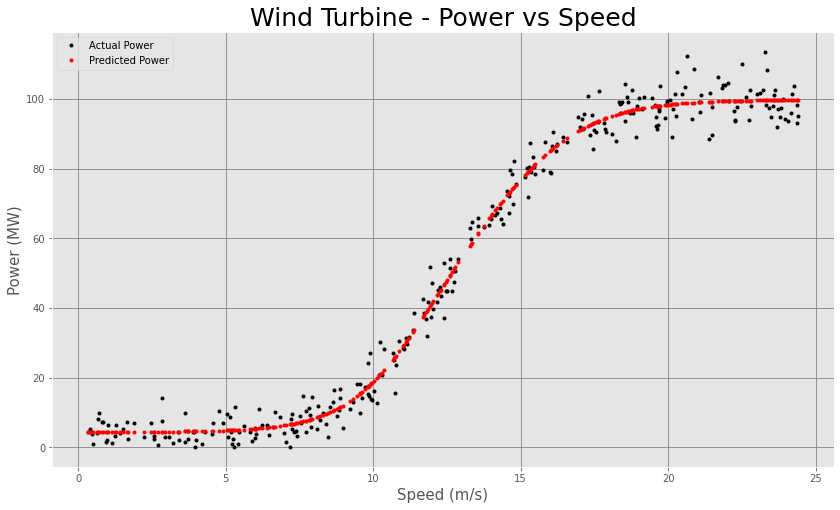

In [60]:
# Now let's see what the train dataset looks like for both the actual data and the predicted values from the model
plt.plot(X_train, y_train, 'k.', label='Actual Power')
plt.plot(X_train, model.predict(X_train), 'r.', label='Predicted Power')
plt.title('Wind Turbine - Power vs Speed', size=25)
plt.xlabel('Speed (m/s)', size=15)
plt.ylabel('Power (MW)', size=15)
# Show grid lines
plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.legend()

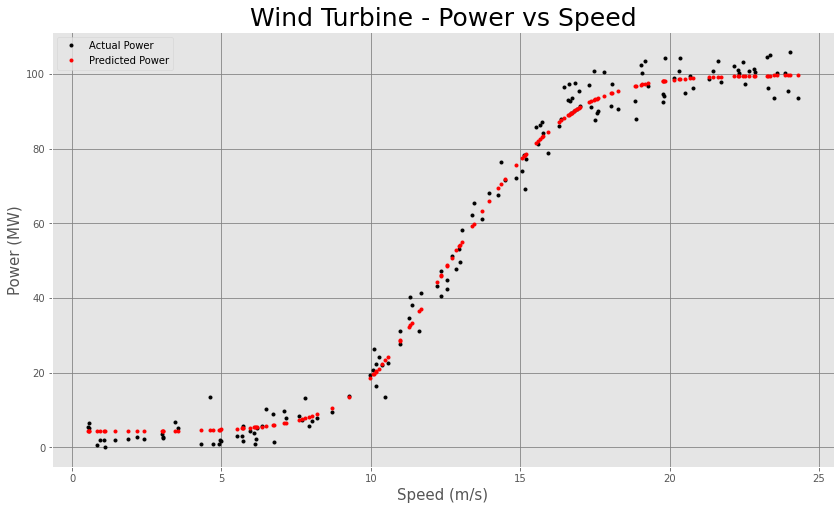

In [61]:
# The ultimate test is how the test dataset fits to its predicted reusults
# Now let's see how the test sample actual and predicted results compare, using the trained model
plt.plot(X_test, y_test, 'k.', label='Actual Power')
plt.plot(X_test, model.predict(X_test), 'r.', label='Predicted Power')
plt.title('Wind Turbine - Power vs Speed', size=25)
plt.xlabel('Speed (m/s)', size=15)
plt.ylabel('Power (MW)', size=15)
# Show grid lines
plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.legend()

In [62]:
# Evaluate the neural network on the test data.
model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 1ms/step - loss: 14.6273


14.627302169799805

In [63]:
y_pred = model.predict(X_test)

In [64]:
y_test.shape = (-1,1)

In [65]:
# Using the R-squared, we can measure the accuracy of the Nueral network using the test dataset
Rsquared = r2_score(y_test, y_pred)
print('R-squared: %.5f' %Rsquared)

R-squared: 0.99101


***

## 6. Overall analysis

Machine learning from two different approaches was used to train and test a dataset. It was found that, in this case, the neural networks were very slightly more accurate. R-Squared was used as a accuracy measure for both approaches. with R-Squared ranging from 0 to 1 (0 => no relationship between the model predited values and the actual recorded values, and 1 => perfect accuracy between the model predited values and the actual recorded values). For the model trained using scikit polynomials, an R-Squared value of 0.988 was observed. For the neural networks, an R-Squared value of ~ 0.991 was observed. Notice how we saw "~" for the neural networks. This is because if the same neural network is run consecutively, it may not result in exactly the same R-Squared value being obtained. However, for 5 differnet neural networks tested above, all 5 yielded consistent R-Squared values > 0.990, which are all better, even if very slightly, than the 0.988 achieved uisng the appraoch with polynomials. 
It is decided to used the Test 5.5 as our model for the Web service. This can be seen in the model.py script